## Setup dependencies

In [1]:
try:
    import google.colab
    import subprocess
    import os.path
    p = subprocess.run(['git', 'rev-parse', '--is-inside-work-tree'], stdout=subprocess.PIPE, universal_newlines=True)
    if p.stdout == 'true\n':
        !git pull
    else:
        if not os.path.isdir('city_dsp_ap'):
            !git clone --depth 1 -q https://github.com/tweyde/city_dsp_ap.git
        %cd city_dsp_ap
except:
    %cd city_dsp_ap

/content/city_dsp_ap


In [2]:
import numpy as np
from scipy import fft, signal
from scipy.io import wavfile
import matplotlib.pyplot as plt
from skimage.transform import rotate
from skimage.util import random_noise
from IPython.display import Audio, display

## Controllable delay line (UG) or filter (PG)

You will need to create a function that applies the desired effect to any input signal, where the effect can be dynamically modified by a control signal. The functions only need to be implemented for offline use, so you don't need to be handle input buffers of arbitrary sizes like in lab 6. It suffices to use a single for loop to run over all samples of the input and control signals, and create the output sample-by-sample.

In both cases, the control signal will be a sine of 2Hz. Create one of the required length yourself. Any signal should work as input signal. You can learn how to [upload your own files](https://colab.research.google.com/notebooks/io.ipynb) into Google Colab, but the easiest will be to use one of the wave files available in the `audio` directory. If you're loading a stereo file, it is allowed to mix it down into a single mono channel before passing it to the effect to simplify processing.

In [3]:
%ls audio/*.wav

audio/20-16000HzExp5sec.wav  audio/carrier.wav*  audio/rockB.wav
audio/20-16000HzLin5sec.wav  audio/rockA.wav


In [4]:
samplerate, carrier_samples = wavfile.read('audio/carrier.wav')

#### UG
Program a controllable delay line. Mix the output with the original input to create a flanging effect. Use the control signal to vary the amount of delay between zero and a maximum value (1 millisecond would be a good default for this, use the samplerate to calculate how much samples this is).

#### PG
Program a controllable FIR filter, i.e. a filter that changes its characteristics over time in response to a control signal. Apply the filter to the signal by implementing a convolution with the filter coefficients in a loop over the samples, just like in lab 7. In order to make the filter respond to the control signal, you can either design two static filters and interpolate between them (like in lab 7), or you can directly manipulate the filter characteristics in the filter design function [`firls`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.firls.html) and call it for every iteration.

In [5]:
def controllable_convolution_loop(samples, samplerate, control_freq, fir_coeff1, fir_coeff2):
    if len(samples.shape) == 2: # if the samples are in stereo
        samples = np.mean(samples, axis=-1) # convert the samples to mono
    duration = len(samples)/samplerate # duration of control sine in seconds (same duration as input signal)
    timepoints = np.arange(samplerate * duration) / samplerate # generating the time points for the sine control signal
    sine_samples = np.sin(2 * np.pi * control_freq * timepoints) # acquiring samples for sine control signal
    filt_len = len(fir_coeff1) # use length of first filter, as each interpolated filter has the name number of coefficients
    samples = np.pad(samples, (filt_len-1, filt_len-1), 'constant', constant_values=(0, 0)) # 0 padding the samples so dot product does not raise errors
    filtered_samples = []
    start = 0 # initiate variable for start index of samples to dot product with filter
    end = filt_len # initiate variable for the corresponding end index
    for factor in sine_samples: # iterate through sine control values
        inter_fir_coeff = fir_coeff1 * factor + fir_coeff2 * (1 - factor) # use control signal sample to interpolate between fir filters
        filt_rev = np.flip(inter_fir_coeff) # reverse filter coefficients
        dot_prod = np.dot(samples[start:end], filt_rev) # dot product on reversed filter with relevant section of samples
        filtered_samples.append(dot_prod) # append to list of filtered samples
        start += 1
        end += 1
    filtered_samples = np.asarray(filtered_samples)
    return filtered_samples

In [6]:
nyquist_frq = samplerate/2 # define nyquist frequency using samplerate
numtaps = 21
fir_coeff1 = signal.firls(numtaps, [0, 2000, 4000, nyquist_frq], [0, 2, 2, 0], fs=samplerate) # creating the first FIR filter (Band Pass) 
fir_coeff2 = signal.firls(numtaps, [0, 1000, 1000, nyquist_frq], [1.5, 1.5, 0, 0], fs=samplerate) # creating the second FIR filter (Low Pass) 

In [7]:
# Apply function to generate filtered samples
filt_samples = controllable_convolution_loop(carrier_samples, samplerate, 2, fir_coeff1, fir_coeff2)

In [8]:
from dsp_ap.signals import AudioSignal

In [9]:
# Listen to the audio below to verify results
original_signal = AudioSignal(carrier_samples, samplerate)
original_signal.play()
filtered_signal = AudioSignal(filt_samples, samplerate)
filtered_signal.play()

#### Frequency Response

Calculating frequency response of system of filters.

In [10]:
original_signal_fft = fft.rfft(carrier_samples * signal.hann(len(carrier_samples)))
filtered_signal_fft = fft.rfft(filt_samples * signal.hann(len(filt_samples)))
freq_response = filtered_signal_fft/original_signal_fft
freq_response_amp = np.abs(freq_response)
freq_response_phase = np.unwrap(np.angle(freq_response))

freq = np.fft.rfftfreq(carrier_samples.size, d=1/samplerate)

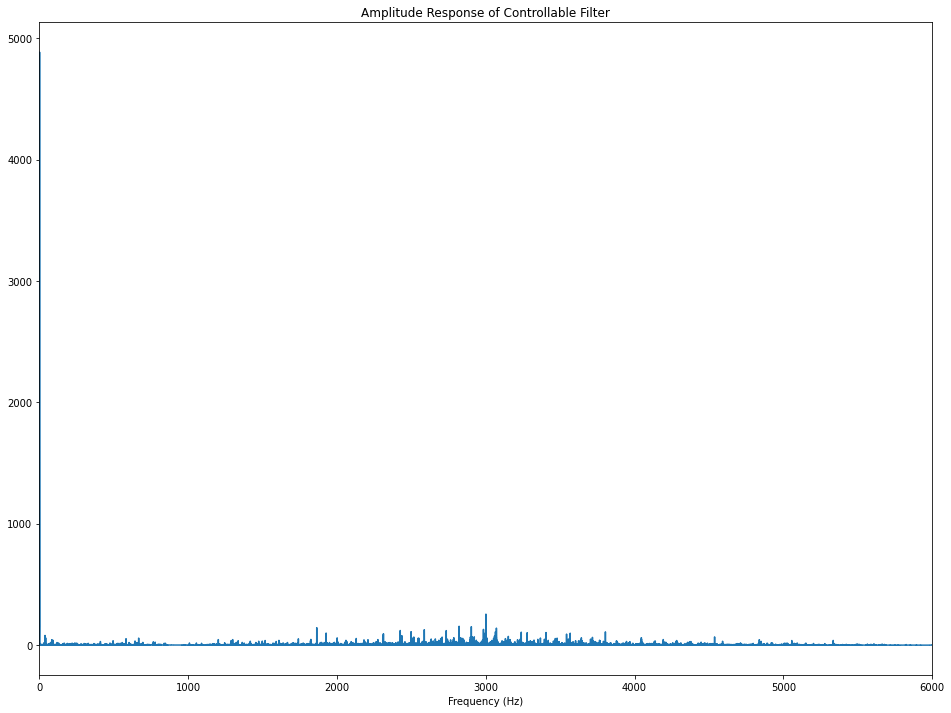

In [11]:
plt.figure(figsize=(16, 12))
plt.title('Amplitude Response of Controllable Filter')
plt.xlim(0, 6000)
plt.xlabel('Frequency (Hz)')
plt.plot(freq, freq_response_amp)
plt.show()

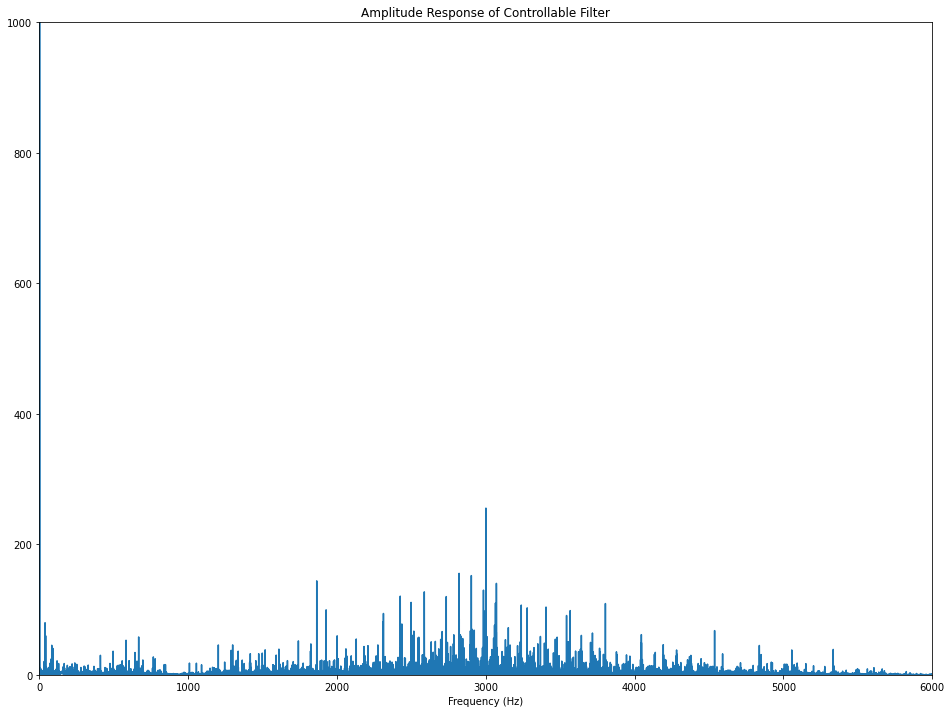

In [12]:
plt.figure(figsize=(16, 12))
plt.title('Amplitude Response of Controllable Filter')
plt.xlim(0, 6000)
plt.ylim(0, 1000)
plt.xlabel('Frequency (Hz)')
plt.plot(freq, freq_response_amp)
plt.show()

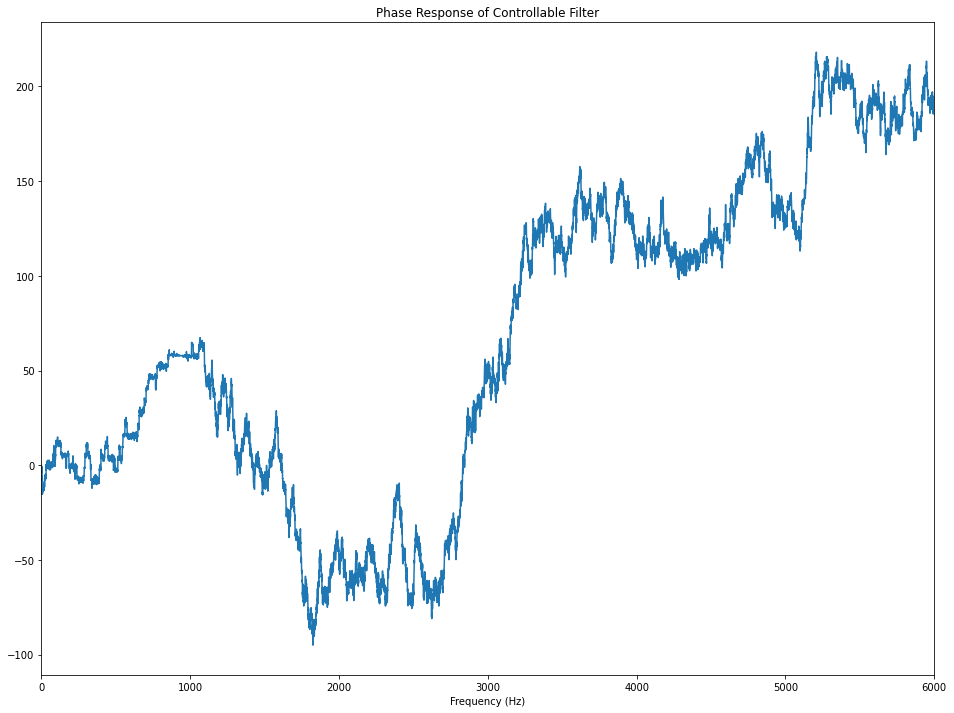

In [13]:
plt.figure(figsize=(16, 12))
plt.title('Phase Response of Controllable Filter')
plt.xlim(0, 6000)
plt.xlabel('Frequency (Hz)')
plt.plot(freq[1:], freq_response_phase[1:])
plt.show()

## Digit recognition (UG & PG)

In this part, you're going to use images of handwritten digits ranging from 0 to 9. They are split in a training set and a test set and stored as text files in `data/digits-training.txt` and `data/digits-test.txt`.

In [14]:
%ls data/digits-*.txt

data/digits-test.txt*  data/digits-training.txt*


In [15]:
from itertools import islice
import re

def read_digit_pixels_and_labels(path):
    with open(path) as f:
        header = list(islice(f, 21))
        pixel_height = [int(x[1]) for x in map(lambda r: re.match('entheight = (\d+)', r), header) if x][0]
        num_digits = [int(x[1]) for x in map(lambda r: re.match('ntot = (\d+)', r), header) if x][0]
        digit_pixels = []
        labels = []
        for _ in range(num_digits):
            chunk = list(islice(f, pixel_height+1))
            digit_pixels.append(np.loadtxt(chunk[:-1]))
            labels.append(int(chunk[-1]))
    return digit_pixels, labels

Since the text files have a custom format, a loader function `read_digit_pixels_and_labels` is provided.

In [16]:
training_digits, training_labels = read_digit_pixels_and_labels('data/digits-training.txt')
test_digits, test_labels = read_digit_pixels_and_labels('data/digits-test.txt')

In [17]:
len(training_digits), len(training_labels), len(test_digits), len(test_labels)

(1934, 1934, 943, 943)

All digits and their associated labels have now been read into lists, so we can use list indexing to access them and, for instance, display them as below.

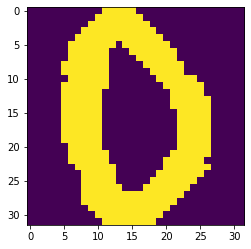

Image of digit 0


In [18]:
index = 1
plt.figure()
plt.imshow(training_digits[index])
plt.show()
print('Image of digit {}'.format(training_labels[index]))

Using this data, your task is to:

1. Create a function for comparing each test image with the collection of training images, using the correlation with each training image without offset (i.e. calculate the sum of the element-wise multiplied images).
2. Estimate the most likely label for each test image by matching with the training image that has maximal correlation.
3. Estimate the accuracy of your system, as a fraction of the correctly estimated test labels over the total number of test images.
4. Use the two-dimensional correlation function [`signal.correlate2d`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate2d.html) to find the best match over all image offsets. For efficiency you can use a subset of the training images, or calculate an average of the training images.
5. Implement variants of the digit recognition system, e.g.
    - use the negatives of the training and test images instead of the positive images
    - use images that are slightly rotated in your training set (using [`rotate`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.rotate) from the `scikit-image.transform` library)
    - use images with some noise added in your training set (using [`random_noise`](https://scikit-image.org/docs/dev/api/skimage.util.html#random-noise) from the `scikit-image.util` library)
6. Report the accuracy of the new system and compare with the accuracy of the previous systems.
7. In the written report, discuss and reason about the different performances of your classifiers.

##Tasks 1 & 2

1) Create a function for comparing each test image with the collection of training images, using the correlation with each training image without offset.

2) Estimate the most likely label for each test image by matching with the training image that has maximal correlation.

In [19]:
# Function for acquiring a list of the predicted labels for each test image using correlation coefficients
def correlation_pred(test_images, train_images, train_labels=training_labels):
    pred_labels = [] # list of predicted labels for test set
    for test_image in test_images:
        correlation_list = [] # list of correlation coeffs for test image with each image in train set
        for train_image in train_images:
            dot_product = np.multiply(test_image, train_image) # dot product of 2 images
            correlation = np.sum(dot_product) # sum dot product
            correlation_list.append(correlation)
        correlation_array = np.asarray(correlation_list)
        max_corr_index = np.argmax(correlation_array) # acquiring index of training image with highest correlation to the test image
        pred_labels.append(train_labels[max_corr_index]) # acquiring and appending corresponding training label
    return pred_labels

In [20]:
pred_labels = correlation_pred(test_digits, training_digits)

## Task 3

Estimate the accuracy of your system, as a fraction of the correctly estimated test labels over the total number of test images.

In [21]:
# Defining function for estimating the accuracy of a set of predicted labels against the corresponding set of true labels
def system_accuracy(predicted_labels):
    num_pred_correct = 0
    for i in range(len(predicted_labels)):
        if predicted_labels[i] == test_labels[i]: 
            num_pred_correct += 1 # if the predicted label matches the real label, add 1 to number of correct predictions
    return num_pred_correct/len(predicted_labels) # returning accuracy as a decimal

In [22]:
# In this cell, we will estimate the accuracy of the correlation-based system
accuracy = system_accuracy(pred_labels)
print('Accuracy of the correlation system: {}'.format(accuracy))

Accuracy of the correlation system: 0.9013785790031813


## Task 4
Use the two-dimensional correlation function signal.correlate2d to find the best match over all image offsets. For efficiency you can use a subset of the training images, or calculate an average of the training images.

In [23]:
# Function for acquiring a list of the predicted labels for each test image using cross-correlation
def cross_corr_pred(test_images, train_images, train_labels=training_labels):
    pred_labels = [] # list of predicted labels for test set
    for test_image in test_images:
        cross_corr_list = [] # list of cross-correlation for test image with all training images 
        for train_image in train_images:
            cross_corr = signal.correlate2d(train_image, test_image, mode='same').max() # obtaining cross-correlation
            cross_corr_list.append(cross_corr)
        cross_corr_array = np.asarray(cross_corr_list) 
        max_cross_corr_index = np.argmax(cross_corr_array) # acquiring index of training image with max cross-correlation to the test image
        pred_labels.append(train_labels[max_cross_corr_index]) # acquiring corresponding training label
    return pred_labels

In [24]:
# Setting length of subset of test set to improve runtime for cross-correlation model
len_test_subset = 20

In [25]:
# In this cell, we will estimate the accuracy of the cross-correlation system
pred_labels2 = cross_corr_pred(test_digits[:len_test_subset], training_digits)
accuracy = system_accuracy(pred_labels2)
print('Accuracy of the cross-correlation system: {}'.format(accuracy))

Accuracy of the cross-correlation system: 1.0


## Task 5
Implement variants of the digit recognition system:

1.   Use the negatives of the training and test images 
2.   Use images that are slightly rotated in your training set (using rotate from the scikit-image.transform library)

3.   Use images with some noise added in your training set (using random_noise from the scikit-image.util library)

In [26]:
from skimage.util import invert, random_noise
from skimage.transform import rotate
from scipy.ndimage import gaussian_filter

### 1. Negative Images

In [27]:
# Function for acquiring negatives of training and test images
def get_negatives(image_list):
    negative_images = []
    for i in range(len(image_list)):
        negative_images.append(invert(image_list[i]))
    return negative_images

In [28]:
neg_test_digits = get_negatives(test_digits)
neg_training_digits = get_negatives(training_digits)

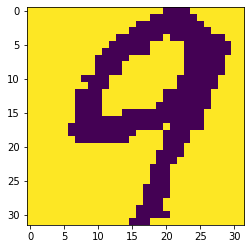

Image of digit 9


In [29]:
# Displaying negative image from test set
plt.figure()
plt.imshow(neg_test_digits[1])
plt.show()
print('Image of digit {}'.format(test_labels[1]))

In [30]:
# Testing correlation model on negative image sets
neg_pred_labels = correlation_pred(neg_test_digits, neg_training_digits)
accuracy = system_accuracy(neg_pred_labels)
print('Accuracy of the correlation system for negative images: {}'.format(accuracy))

Accuracy of the correlation system for negative images: 0.9088016967126193


In [31]:
# Testing cross-correlation model on negative image sets
neg_pred_labels2 = cross_corr_pred(neg_test_digits[:len_test_subset], neg_training_digits)
accuracy = system_accuracy(neg_pred_labels2)
print('Accuracy of the cross-correlation system for negative images: {}'.format(accuracy))

Accuracy of the cross-correlation system for negative images: 0.75


### 2. Rotated Images

In [32]:
# Rotating images in training set
def rotate_training_images(angle):
    rotated_training_digits = []
    for i in range(len(training_digits)):
        rotated_training_digits.append(rotate(training_digits[i], angle))
    return rotated_training_digits

In [35]:
# Testing correlation model using various rotated training sets 
rotated_accuracy_dict = {}
for angle in [10, -10]:
    rotated_training_digits = rotate_training_images(angle)
    rotated_pred_labels = correlation_pred(test_digits, rotated_training_digits)
    accuracy = system_accuracy(rotated_pred_labels)
    rotated_accuracy_dict[angle] = accuracy
    print('Accuracy of the correlation system using training images rotated anti-clockwise by {} degrees: {}'.format(angle, accuracy))

Accuracy of the correlation system using training images rotated anti-clockwise by 10 degrees: 0.7656415694591728
Accuracy of the correlation system using training images rotated anti-clockwise by -10 degrees: 0.8271474019088016


In [36]:
# Testing cross-correlation model using various rotated training sets
rotated_accuracy_dict2 = {}
for angle in [10, -10]:
    rotated_training_digits = rotate_training_images(angle)
    rotated_pred_labels2 = cross_corr_pred(test_digits[:len_test_subset], rotated_training_digits)
    accuracy = system_accuracy(rotated_pred_labels2)
    rotated_accuracy_dict2[angle] = accuracy
    print('Accuracy of the cross-correlation system using training images rotated anti-clockwise by {} degrees: {}'.format(angle, accuracy))

Accuracy of the cross-correlation system using training images rotated anti-clockwise by 10 degrees: 0.9
Accuracy of the cross-correlation system using training images rotated anti-clockwise by -10 degrees: 0.8


### 3. Noisy Images

In [37]:
# Adding noise to training images
noisy_training_digits = []
for i in range(len(training_digits)):
    noisy_training_digits.append(random_noise(training_digits[i]))

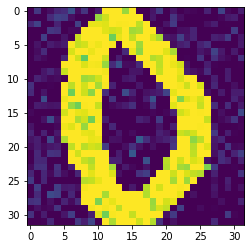

Image of digit 0


In [38]:
# Displaying added-noise image from training set
plt.figure()
plt.imshow(noisy_training_digits[1])
plt.show()
print('Image of digit {}'.format(training_labels[1]))

In [39]:
# Testing correlation model on noisy training image set
noisy_pred_labels = correlation_pred(test_digits, noisy_training_digits)
accuracy = system_accuracy(noisy_pred_labels)
print('Accuracy of the correlation system using noisy training images: {}'.format(accuracy))

Accuracy of the correlation system using noisy training images: 0.8992576882290562


In [40]:
# Testing cross-correlation model using noisy training images
noisy_pred_labels2 = cross_corr_pred(test_digits[:len_test_subset], noisy_training_digits)
accuracy = system_accuracy(noisy_pred_labels2)
print('Accuracy of the cross-correlation system using noisy training images: {}'.format(accuracy))

Accuracy of the cross-correlation system using noisy training images: 1.0


### 4. Gaussian Filtered Images

Running both models on training and test images that have been blurred using Gaussian filtering.

In [41]:
# Function to apply Gaussian filter to training and test sets
def apply_gaussian_filter(image_list):
    filtered_images = []
    for i in range(len(image_list)):
        filtered_images.append(gaussian_filter(image_list[i], 1, mode='constant', cval=0)) # applying Gaussian filter on zero-padded image with sigma 1
    return filtered_images

In [42]:
gaussian_test_digits = apply_gaussian_filter(test_digits)
gaussian_training_digits = apply_gaussian_filter(training_digits)

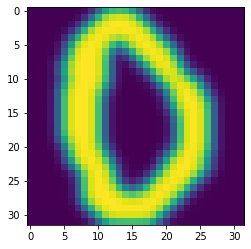

Image of digit 0


In [43]:
# Displaying Gaussian-filtered image from training set
plt.figure()
plt.imshow(gaussian_training_digits[1])
plt.show()
print('Image of digit {}'.format(training_labels[1]))

In [44]:
# Testing correlation model on Gaussian filtered image sets
gaussian_pred_labels = correlation_pred(gaussian_test_digits, gaussian_training_digits)
accuracy = system_accuracy(gaussian_pred_labels)
print('Accuracy of the correlation system using Gaussian filtered images: {}'.format(accuracy))

Accuracy of the correlation system using Gaussian filtered images: 0.7868504772004242


In [45]:
# Testing cross-correlation model using Gaussian filtered image sets
gaussian_pred_labels2 = cross_corr_pred(gaussian_test_digits[:len_test_subset], gaussian_training_digits)
accuracy = system_accuracy(gaussian_pred_labels2)
print('Accuracy of the cross-correlation system using Gaussian filtered images: {}'.format(accuracy))

Accuracy of the cross-correlation system using Gaussian filtered images: 0.9


### 5. Averaged Training Digits

Running both models on a new training set containing a single image for each digit, obtained by taking the mean over the images belonging to the specified digit.

In [46]:
# Function to take the mean image of all images of a specified digit in the training set
def mean_digit_images(digit):
    digit_indices = [i for i, label in enumerate(training_labels) if label == digit] # list of indices of images of specified digit in training set
    digit_images = [training_digits[i] for i in digit_indices] # list of images of specified digit in training set
    digit_images = np.array(digit_images) # convert to array
    return np.mean(digit_images, axis=0) # take mean across all images

In [47]:
mean_train_digits = [mean_digit_images(digit) for digit in range(10)]
mean_train_labels = [*range(10)]

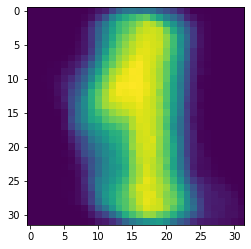

Image of digit 1


In [48]:
plt.figure()
plt.imshow(mean_train_digits[1])
plt.show()
print('Image of digit {}'.format(mean_train_labels[1]))

In [49]:
# Testing correlation model using mean digit test image set
mean_pred_labels = correlation_pred(test_digits, mean_train_digits, mean_train_labels)

# Calculating accuracy 
accuracy = system_accuracy(mean_pred_labels)
print('Accuracy of the correlation system using mean digit training image set: {}'.format(accuracy))

Accuracy of the correlation system using mean digit training image set: 0.8738069989395546


In [50]:
# Testing cross-correlation model using mean digit test image set
mean_pred_labels2 = cross_corr_pred(test_digits, mean_train_digits, mean_train_labels)

# Calculating accuracy
accuracy = system_accuracy(mean_pred_labels2)
print('Accuracy of the cross-correlation system using mean digit test image set: {}'.format(accuracy))

Accuracy of the cross-correlation system using mean digit test image set: 0.887592788971368


## Task 6

Report the accuracy of the new system and compare with the accuracy of the previous systems.

### Correlation Systems

In [53]:
# Testing the accuracy of all of the correlation systems
accuracy = system_accuracy(pred_labels)
print('Accuracy of the correlation system: {}'.format(accuracy))

accuracy = system_accuracy(neg_pred_labels)
print('Accuracy of the correlation system for negative images: {}'.format(accuracy))

for angle in rotated_accuracy_dict.keys():
    print('Accuracy of the correlation system using training images rotated anti-clockwise by {} degrees: {}'.format(angle, rotated_accuracy_dict[angle]))

accuracy = system_accuracy(noisy_pred_labels)
print('Accuracy of the correlation system using noisy training images: {}'.format(accuracy))

accuracy = system_accuracy(gaussian_pred_labels)
print('Accuracy of the correlation system using Gaussian filtered images: {}'.format(accuracy))

accuracy = system_accuracy(mean_pred_labels)
print('Accuracy of the correlation system using mean digit training image set: {}'.format(accuracy))

Accuracy of the correlation system: 0.9013785790031813
Accuracy of the correlation system for negative images: 0.9088016967126193
Accuracy of the correlation system using training images rotated anti-clockwise by 10 degrees: 0.7656415694591728
Accuracy of the correlation system using training images rotated anti-clockwise by -10 degrees: 0.8271474019088016
Accuracy of the correlation system using noisy training images: 0.8992576882290562
Accuracy of the correlation system using Gaussian filtered images: 0.7868504772004242
Accuracy of the correlation system using mean digit training image set: 0.8738069989395546


### Cross-correlation Systems

In [54]:
# Testing the accuracy of all of the cross-correlation systems
accuracy = system_accuracy(pred_labels2)
print('Accuracy of the cross-correlation system: {}'.format(accuracy))

accuracy = system_accuracy(neg_pred_labels2)
print('Accuracy of the cross-correlation system for negative images: {}'.format(accuracy))

for angle in rotated_accuracy_dict2.keys():
    print('Accuracy of the cross-correlation system using training images rotated anti-clockwise by {} degrees: {}'.format(angle, rotated_accuracy_dict2[angle]))

accuracy = system_accuracy(noisy_pred_labels2)
print('Accuracy of the cross-correlation system using noisy training images: {}'.format(accuracy))

accuracy = system_accuracy(gaussian_pred_labels2)
print('Accuracy of the cross-correlation system using Gaussian filtered images: {}'.format(accuracy))

accuracy = system_accuracy(mean_pred_labels2)
print('Accuracy of the cross-correlation system using mean digit training image set: {}'.format(accuracy))

Accuracy of the cross-correlation system: 1.0
Accuracy of the cross-correlation system for negative images: 0.75
Accuracy of the cross-correlation system using training images rotated anti-clockwise by 10 degrees: 0.9
Accuracy of the cross-correlation system using training images rotated anti-clockwise by -10 degrees: 0.8
Accuracy of the cross-correlation system using noisy training images: 1.0
Accuracy of the cross-correlation system using Gaussian filtered images: 0.9
Accuracy of the cross-correlation system using mean digit training image set: 0.887592788971368


## Time series prediction with financial data (UG & PG)

In this part, you're going to use long term US stock market data (monthly indices, dividends, earnings, etc. since 1871). Information about the data provenance and references can be found at http://www.econ.yale.edu/~shiller/data.htm (especially the 2nd paragraph). The data is available in the file `data/financial_data.csv`.

It is stored as comma-separated numerical values, with a header containing column names. Therefore we can use [`np.genfromtxt`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.genfromtxt.html#numpy.genfromtxt) to read it.

In [55]:
financial = np.genfromtxt('data/financial_data.csv', delimiter=',', skip_header=2, names=True)

The result is a structured array, which means that we can access each of the columns in the table by its name. The list of all colums can be found below.

In [56]:
financial.dtype.names

('Date',
 'SP_Comp_P',
 'Dividend_D',
 'Earnings_E',
 'Consumer_Price_Index_CPI',
 'Date_Fraction',
 'Long_Interest_Rate_GS10',
 'Real_Price',
 'Real_Dividend',
 'Real_Earnings',
 'Cyclically_Adjusted_Price_Earnings_Ratio_PE10_or_CAPE')

You can access the columns using their names between square brackets, like you would for a dictionary. It's advised to store the columns you need in helper variables, to avoid long statements resulting from the long column names.

In [57]:
date = financial['Date']
real_price = financial['Real_Price']

Now you can easily use the data, for instance to plot it.

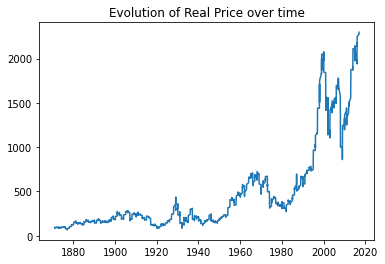

In [58]:
plt.figure()
plt.plot(date, real_price)
plt.title('Evolution of Real Price over time')
plt.show()

Using this data, your task is to:

1. Look for long term trends on a linear and log scale and de-trend the data first.
2. Calculate the FFT of the signal of interest, to estimate possible periodicities. You can use a window to avoid spectral leaking.
3. Refine your analysis by adjusting the size of the dataset (e.g. if you model annual patterns, make sure your dataset size is a multiple of 12).

##Task 1

Look for long term trends on a linear and log scale and de-trend the data first.

### 1. Searching for Long Term Trends

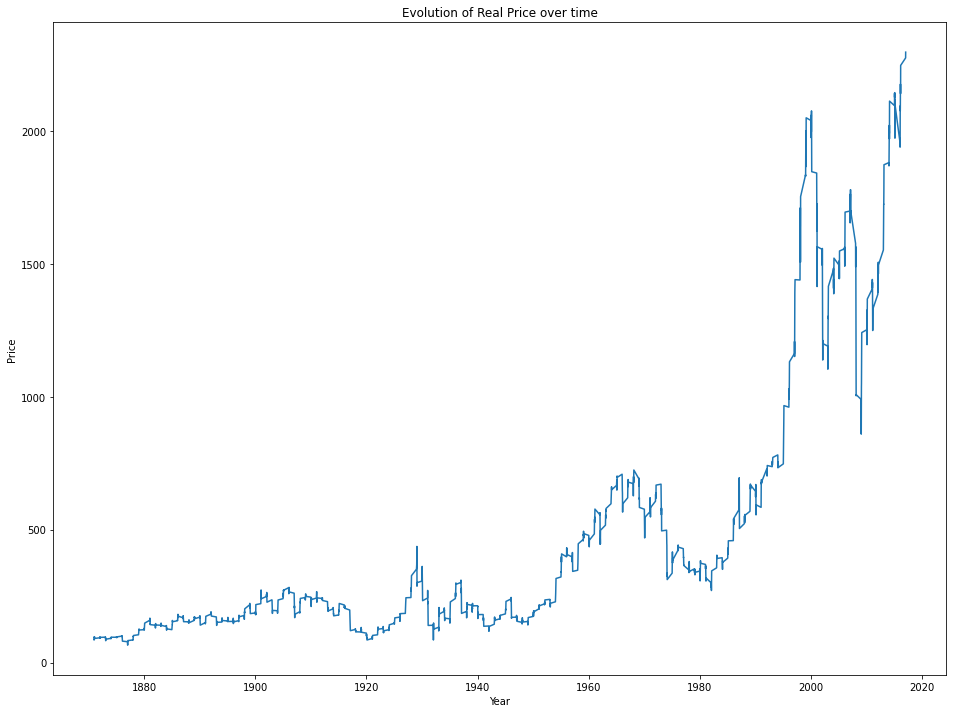

In [59]:
# Checking long-term trends
plt.figure(figsize=(16, 12))
plt.title('Evolution of Real Price over time')
plt.plot(date, real_price)
plt.xlabel('Year')
plt.ylabel('Price')
plt.show()

In [60]:
def take_moving_avg(time_series, num_periods):
      moving_avg = signal.lfilter(np.full(num_periods, 1/num_periods), [1], time_series)
      return moving_avg

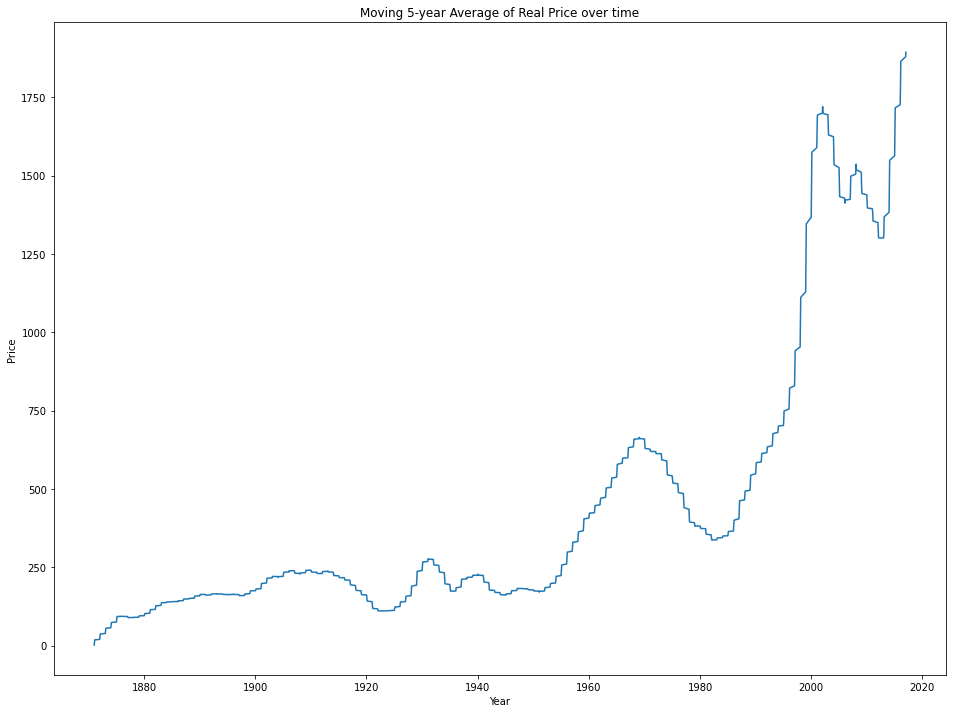

In [61]:
plt.figure(figsize=(16, 12))
span = 60
plt.title('Moving {}-year Average of Real Price over time'.format(int(span/12)))
plt.xlabel('Year')
plt.ylabel('Price')
moving_avg = take_moving_avg(real_price, span)
plt.plot(date, moving_avg)
#plt.plot(date, real_price)
plt.show()

In [62]:
def take_exp_weighted_avg(time_series, w):
      moving_avg = signal.lfilter([w], [1, 1-w], time_series)
      return moving_avg

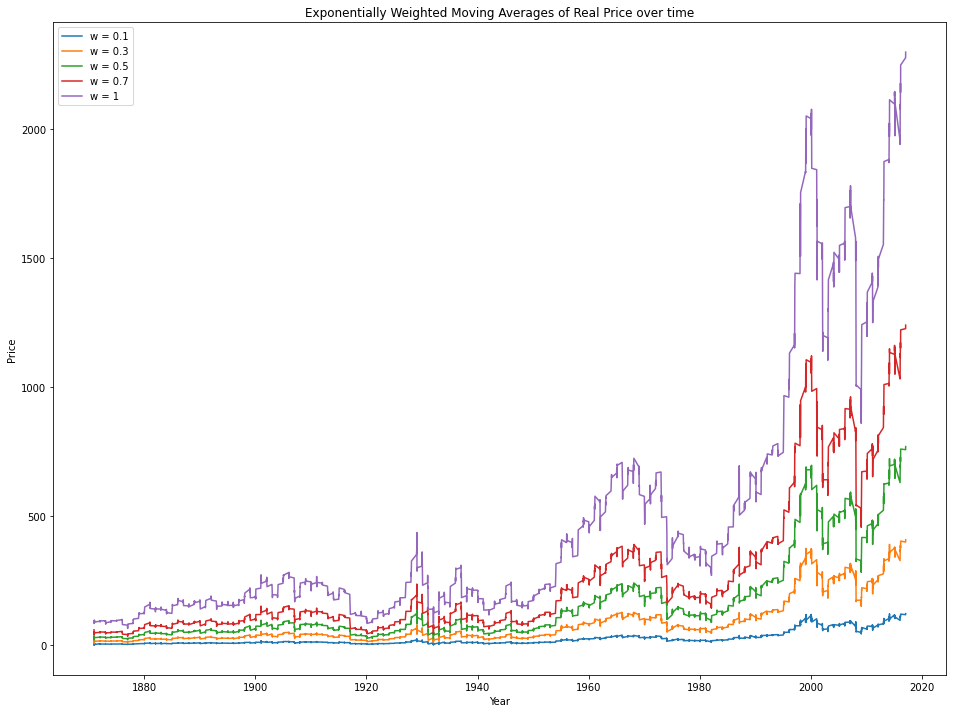

In [63]:
plt.figure(figsize=(16, 12))
plt.title('Exponentially Weighted Moving Averages of Real Price over time')
plt.xlabel('Year')
plt.ylabel('Price')
for w in [0.1, 0.3, 0.5, 0.7, 1]:
    exp_weighted_avg = take_exp_weighted_avg(real_price, w)
    plt.plot(date, exp_weighted_avg, label='w = {}'.format(w))
    plt.legend(loc="upper left")
plt.show()

Both of these graphs indicate either a quadratic or exponential trend. Let's convert the y-axis to a log scale.

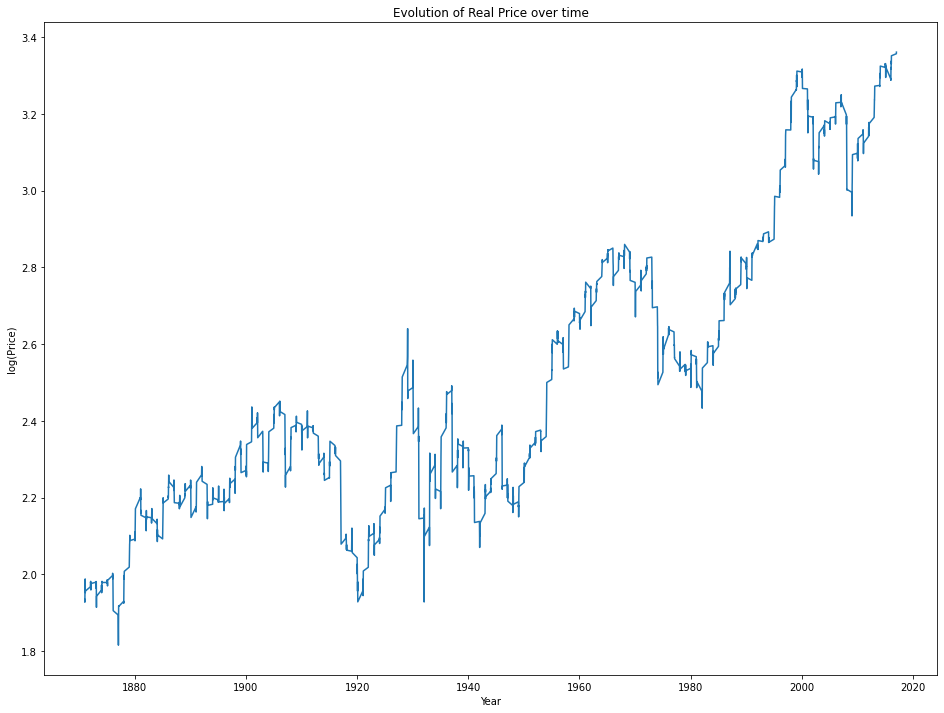

In [64]:
# Checking long-term trends on log scale
plt.figure(figsize=(16, 12))
plt.title('Evolution of Real Price over time')
plt.plot(date, np.log10(real_price))
plt.xlabel('Year')
plt.ylabel('log(Price)')
plt.show()

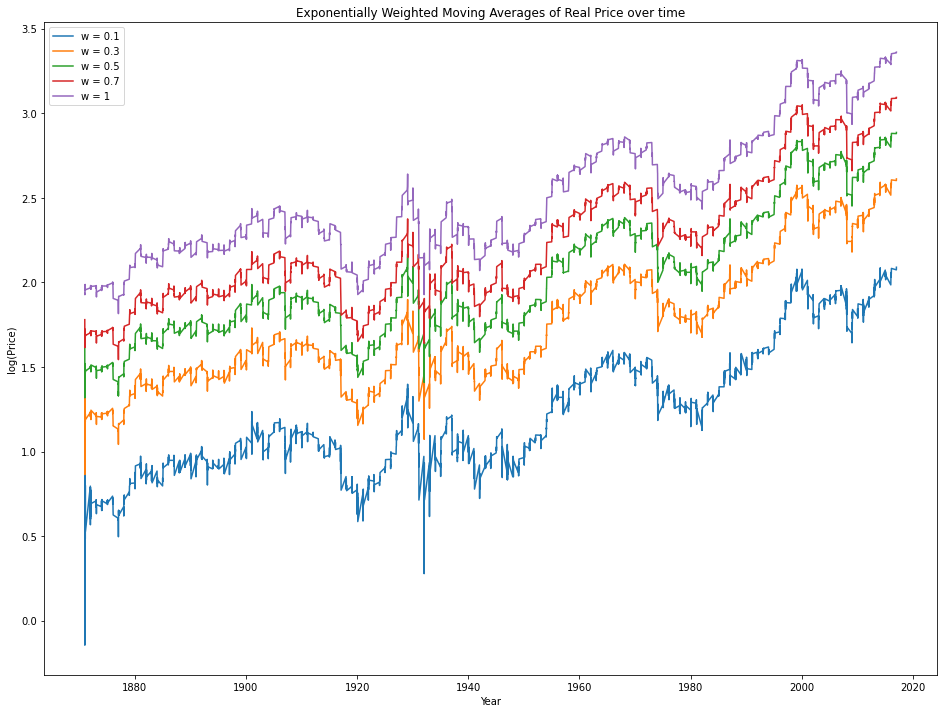

In [65]:
plt.figure(figsize=(16, 12))
plt.title('Exponentially Weighted Moving Averages of Real Price over time')
plt.xlabel('Year')
plt.ylabel('log(Price)')
for w in [0.1, 0.3, 0.5, 0.7, 1]:
    exp_weighted_avg = take_exp_weighted_avg(real_price, w)
    plt.plot(date, np.log10(exp_weighted_avg), label='w = {}'.format(w))
    plt.legend(loc="upper left")
plt.show()

###2. Trend Estimation

Based on the graphs of the time series in the previous section, the time series has a quadratic or exponential trend. We will now use polyfit in order to find trends in the log scale, which can be converted back to the linear scale, as well as the linear scale itself.

In [66]:
period_list = np.arange(len(date)) # converting dates to a period variable, where 1 period = 1 month
quad_coeff = np.polyfit(period_list, real_price, 2) # acquiring coefficients of quadratic trend estimation
quad_values = []
for x in period_list: # acquiring y values of quadratic trend estimation for x values (dates)
    y = quad_coeff[2] + x * quad_coeff[1] + x**2 * quad_coeff[0]
    quad_values.append(y)

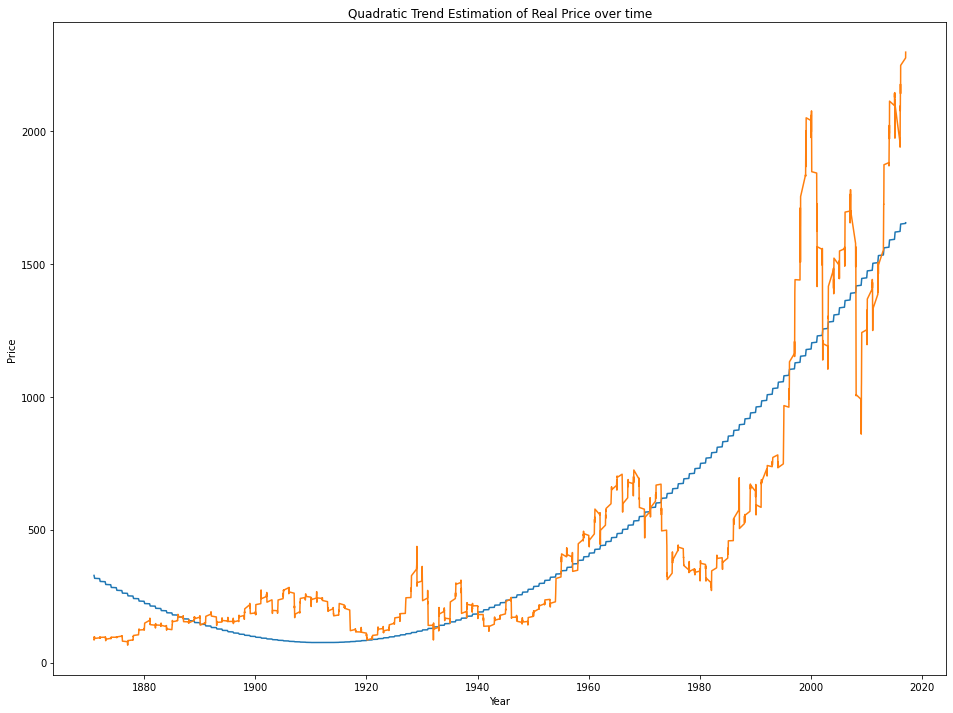

In [67]:
plt.figure(figsize=(16, 12))
plt.title('Quadratic Trend Estimation of Real Price over time')
plt.xlabel('Year')
plt.ylabel('Price')
plt.plot(date, quad_values, label='Quadratic Trend')
plt.plot(date, real_price, label='Original Timeseries')
plt.show()

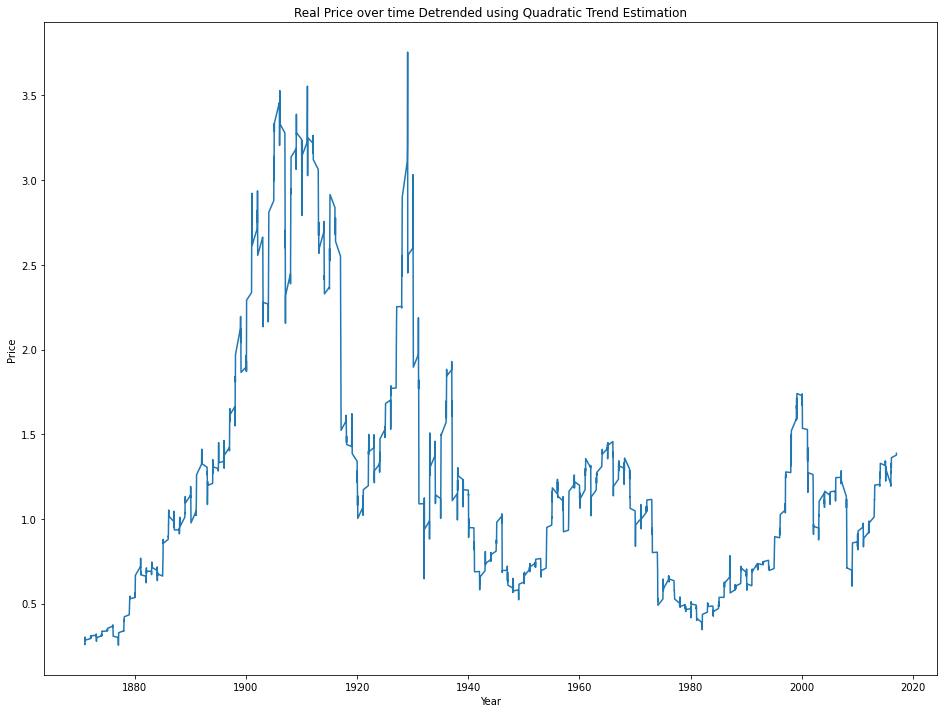

In [68]:
# Detrending the data using the quadratic trend estimation values
# price_quad_detrend = real_price - quad_values
price_quad_detrend = real_price/quad_values

plt.figure(figsize=(16, 12))
plt.title('Real Price over time Detrended using Quadratic Trend Estimation')
plt.xlabel('Year')
plt.ylabel('Price')
plt.plot(date, price_quad_detrend)
plt.show()

In [69]:
log_lin_coeff = np.polyfit(period_list, np.log10(real_price), 1) # acquiring coefficients of linear log trend estimation
log_lin_values = []
for x in period_list: # acquiring y values of estimation for x values (dates)
    y = 10**(log_lin_coeff[1] + x * log_lin_coeff[0])
    log_lin_values.append(y)

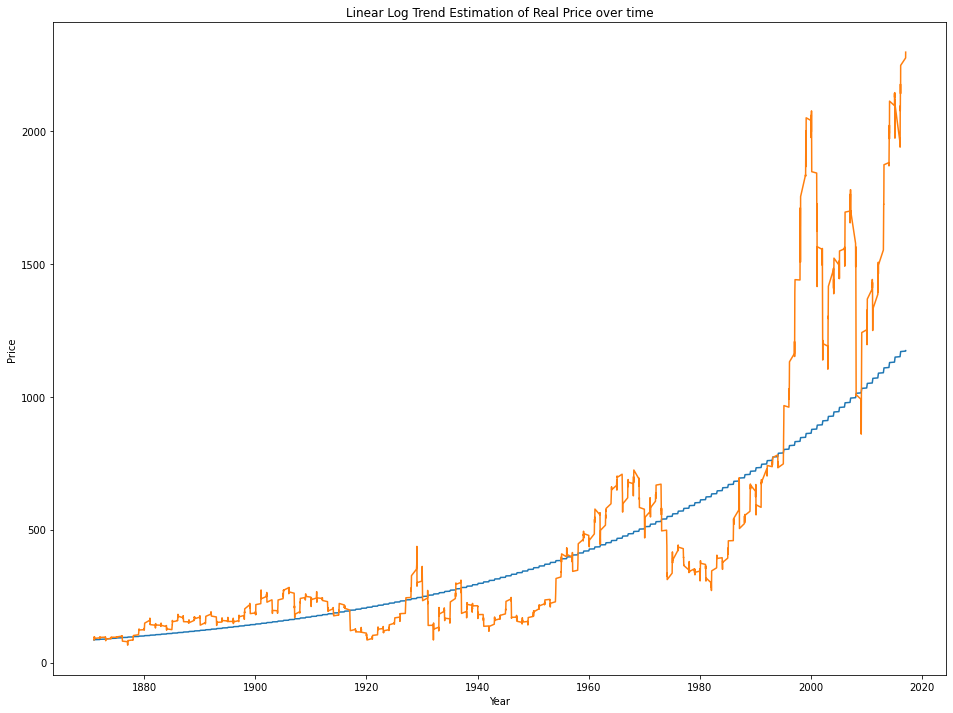

In [70]:
plt.figure(figsize=(16, 12))
plt.title('Linear Log Trend Estimation of Real Price over time')
plt.xlabel('Year')
plt.ylabel('Price')
plt.plot(date, log_lin_values, label='Linear Log Trend')
plt.plot(date, real_price, label='Original Timeseries')
plt.show()

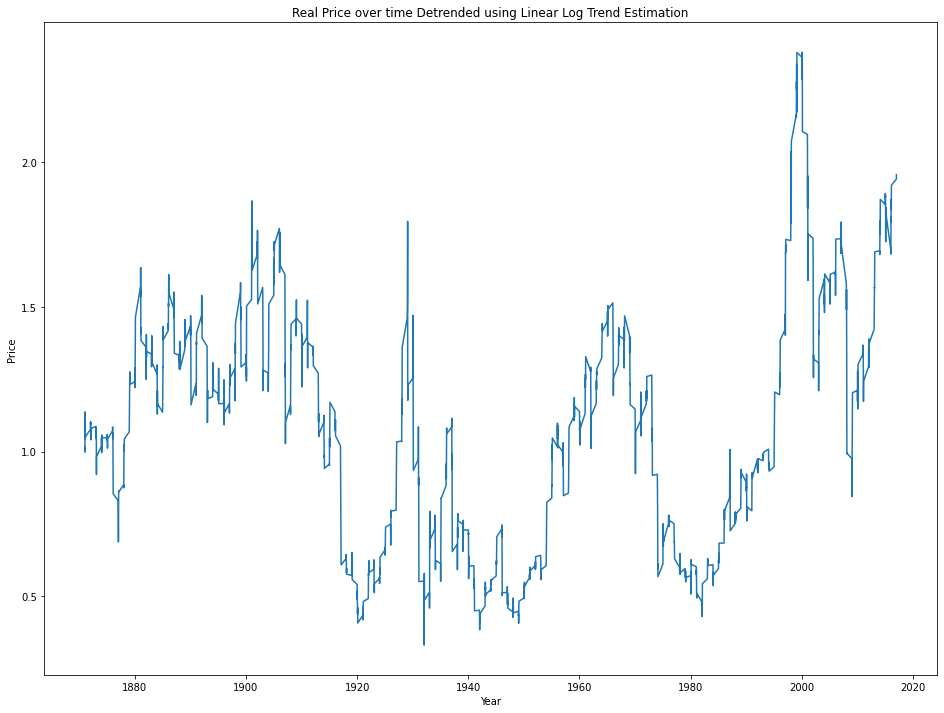

In [71]:
# Detrending the data using the linear log trend estimation values
# price_lin_log_detrend = real_price - log_lin_values
price_lin_log_detrend = real_price/log_lin_values

plt.figure(figsize=(16, 12))
plt.title('Real Price over time Detrended using Linear Log Trend Estimation')
plt.xlabel('Year')
plt.ylabel('Price')
plt.plot(date, price_lin_log_detrend)
plt.show()

In [72]:
log_quad_coeff = np.polyfit(period_list, np.log10(real_price), 2) # acquiring coefficients of quadratic log trend estimation
log_quad_values = []
for x in period_list: # acquiring y values of estimation for x values (dates)
    y = 10**(log_quad_coeff[2] + x * log_quad_coeff[1] + x**2 * log_quad_coeff[0])
    log_quad_values.append(y)

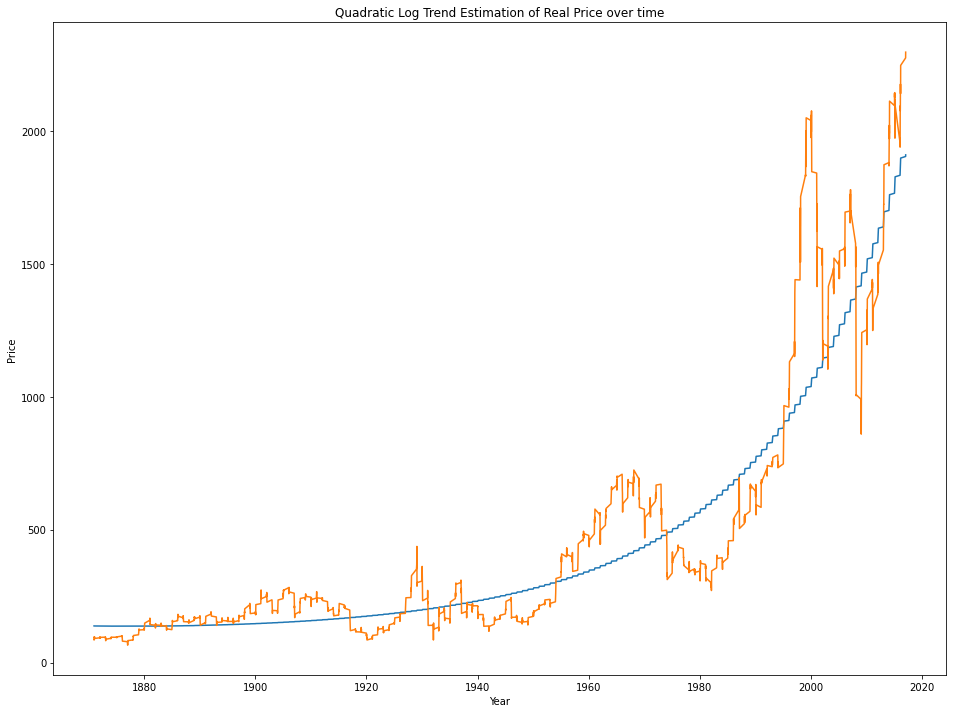

In [73]:
plt.figure(figsize=(16, 12))
plt.title('Quadratic Log Trend Estimation of Real Price over time')
plt.xlabel('Year')
plt.ylabel('Price')
plt.plot(date, log_quad_values, label='Quadratic Log Trend')
plt.plot(date, real_price, label='Original Timeseries')
plt.show()

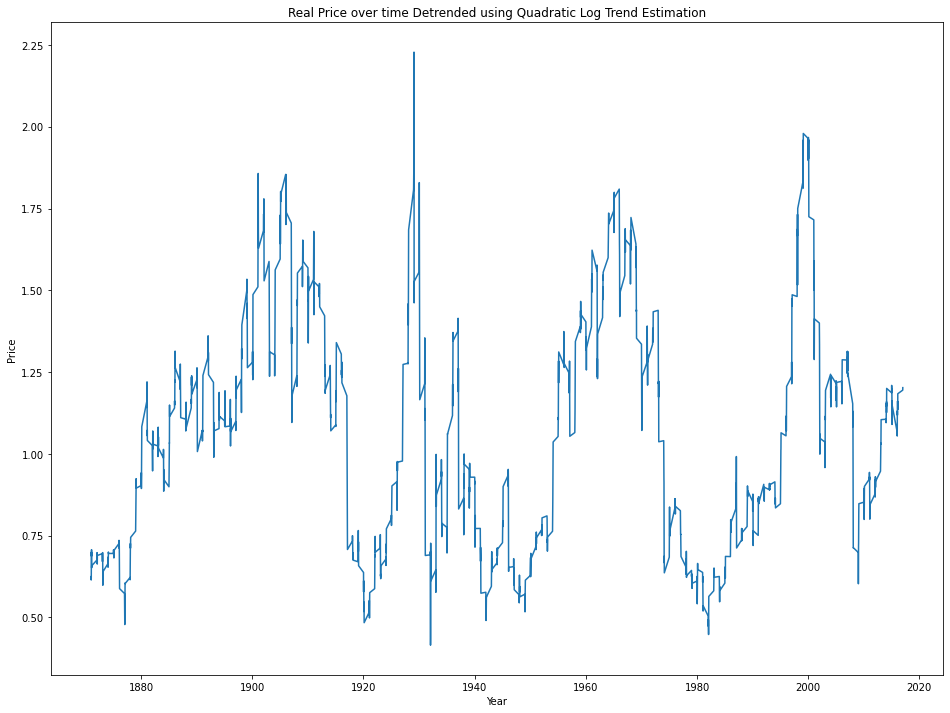

In [74]:
# Detrending the data using the quadratic log trend estimation values
# price_quad_log_detrend = real_price - log_quad_values
price_quad_log_detrend = real_price/log_quad_values


plt.figure(figsize=(16, 12))
plt.title('Real Price over time Detrended using Quadratic Log Trend Estimation')
plt.xlabel('Year')
plt.ylabel('Price')
plt.plot(date, price_quad_log_detrend)
plt.show()

In [75]:
print('Variance of the original dataset: {}'.format(np.var(real_price)))
print('Variance of the dataset detrended using quadratic trend estimation: {}'.format(np.var(price_quad_detrend)))
print('Variance of the dataset detrended using linear log trend estimation: {}'.format(np.var(price_lin_log_detrend)))
print('Variance of the dataset detrended using quadratic log trend estimation: {}'.format(np.var(price_quad_log_detrend)))

Variance of the original dataset: 246575.32708786492
Variance of the dataset detrended using quadratic trend estimation: 0.5498837486815561
Variance of the dataset detrended using linear log trend estimation: 0.16545735606926273
Variance of the dataset detrended using quadratic log trend estimation: 0.12576847287199958


##Task 2

Calculate the FFT of the signal of interest, to estimate possible periodicities. You can use a window to avoid spectral leaking.

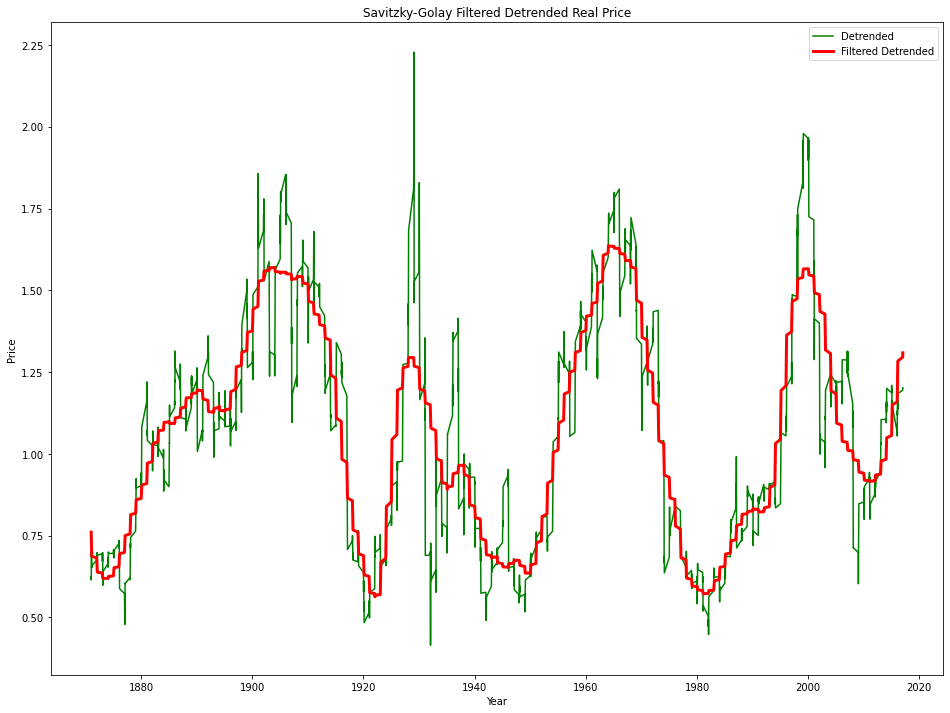

In [76]:
savgol_filtered_detrend = signal.savgol_filter(price_quad_log_detrend, 159, 3)
plt.figure(figsize=(16, 12))
plt.title('Savitzky-Golay Filtered Detrended Real Price')
plt.xlabel('Year')
plt.ylabel('Price')
plt.plot(date, price_quad_log_detrend, 'g', label='Detrended')
plt.plot(date, savgol_filtered_detrend, 'r', linewidth=3, label='Filtered Detrended')
plt.legend()
plt.show()

### 3. Calculating FFTs

In [77]:
timeseries_samplerate = 12/ (60 * 60 * 24 * 365) # 12 samples a year, converted to Hz
price_quad_log_fft = fft.rfft(price_quad_log_detrend)
savgol_filtered_fft = fft.rfft(savgol_filtered_detrend)
fft_freq = np.fft.rfftfreq(savgol_filtered_detrend.size, d=1/timeseries_samplerate)

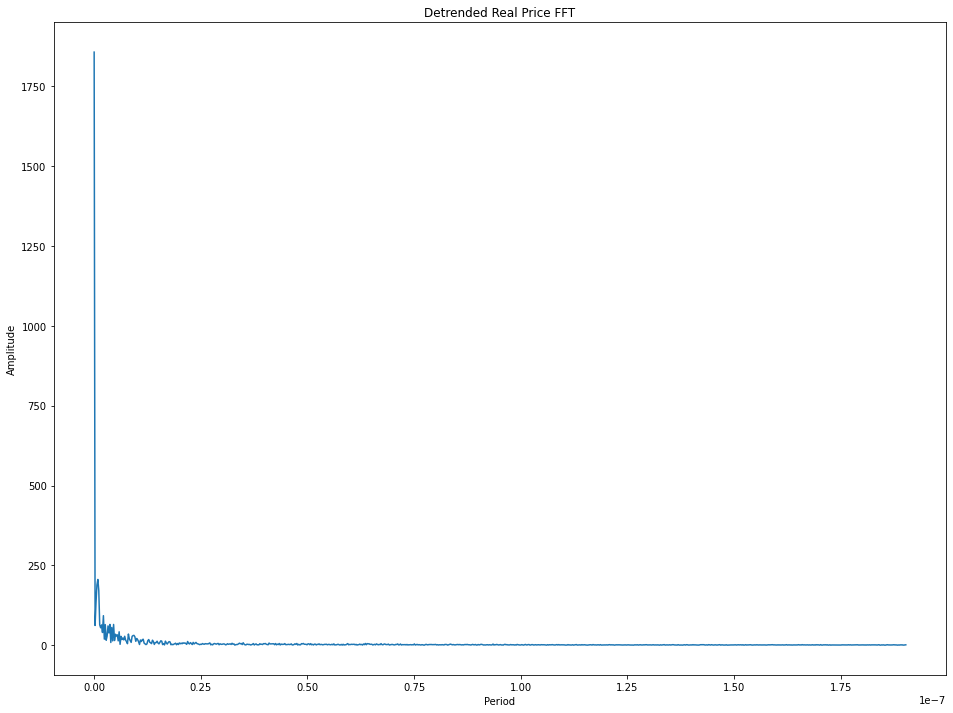

In [78]:
plt.figure(figsize=(16, 12))
plt.title('Detrended Real Price FFT')
plt.plot(fft_freq, np.abs(price_quad_log_fft))
plt.xlabel('Period')
plt.ylabel('Amplitude')
plt.show()

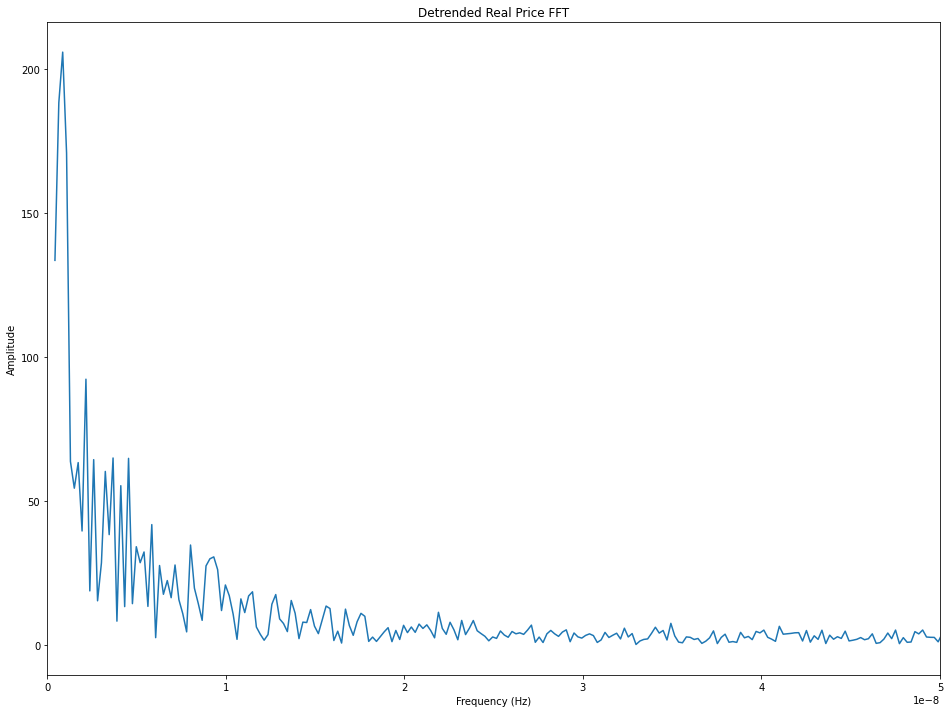

In [79]:
plt.figure(figsize=(16, 12))
plt.title('Detrended Real Price FFT')
plt.plot(fft_freq[2:], np.abs(price_quad_log_fft)[2:])
plt.xlabel('Frequency (Hz)')
plt.xlim(0, 0.5*10**-7)
plt.ylabel('Amplitude')
plt.show()

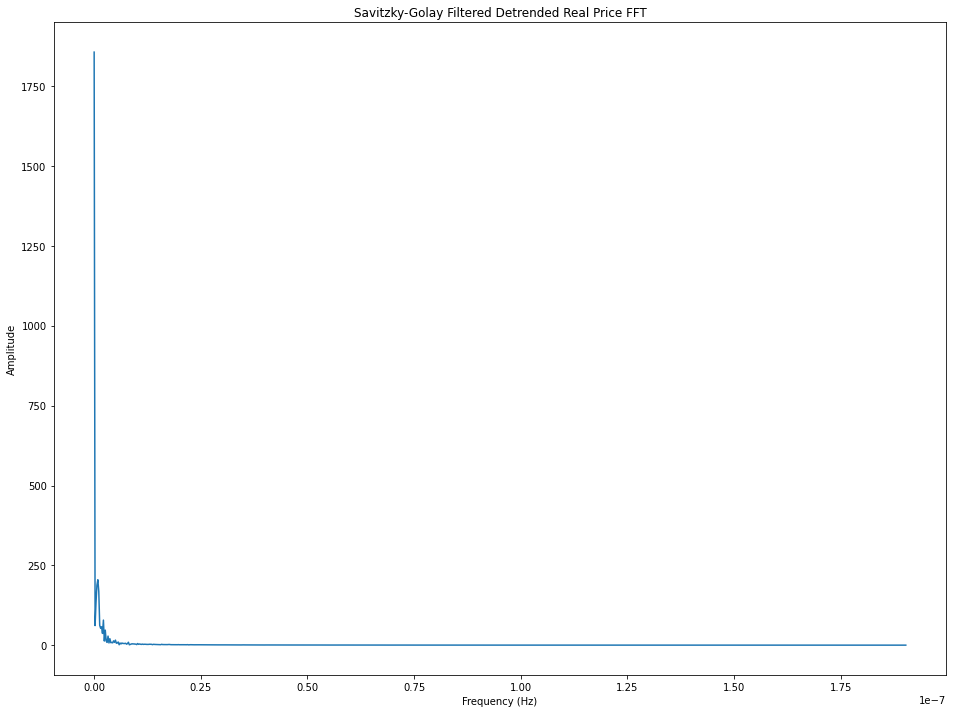

In [80]:
plt.figure(figsize=(16, 12))
plt.title('Savitzky-Golay Filtered Detrended Real Price FFT')
plt.plot(fft_freq, np.abs(savgol_filtered_fft))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.show()

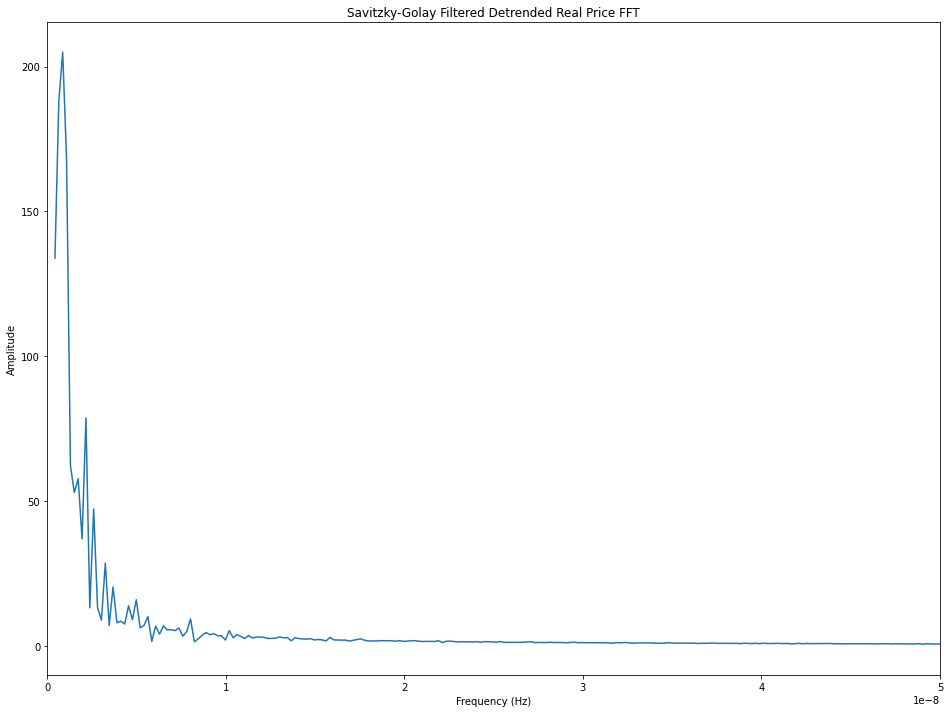

In [81]:
plt.figure(figsize=(16, 12))
plt.title('Savitzky-Golay Filtered Detrended Real Price FFT')
plt.plot(fft_freq[2:], np.abs(savgol_filtered_fft)[2:])
plt.xlabel('Frequency (Hz)')
plt.xlim(0, 0.5*10**-7)
plt.ylabel('Amplitude')
plt.show()

In [82]:
quad_log_peak_indices, quad_log_peak_amplitudes = signal.find_peaks(np.abs(price_quad_log_fft), height=90)
savgol_peak_indices, savgol_peak_amplitudes = signal.find_peaks(np.abs(savgol_filtered_fft), height=90)

In [83]:
def plot_peaks(fft, peak_indices, freq_list):
    peak_freq = []
    peak_freq_y = []
    for i in peak_indices:
        peak_freq.append(freq_list[i])
        peak_freq_y.append(np.abs(fft)[i])
    plt.figure(figsize=(16, 12))
    plt.title('Peaks of Detrended Real Price FFT')
    plt.plot(fft_freq[2:], np.abs(fft)[2:])
    plt.plot(peak_freq, peak_freq_y, 'ro')
    plt.xlabel('Freq (Hz)')
    plt.xlim(0, 0.5*10**-7)
    plt.ylabel('Amplitude')
    plt.show()

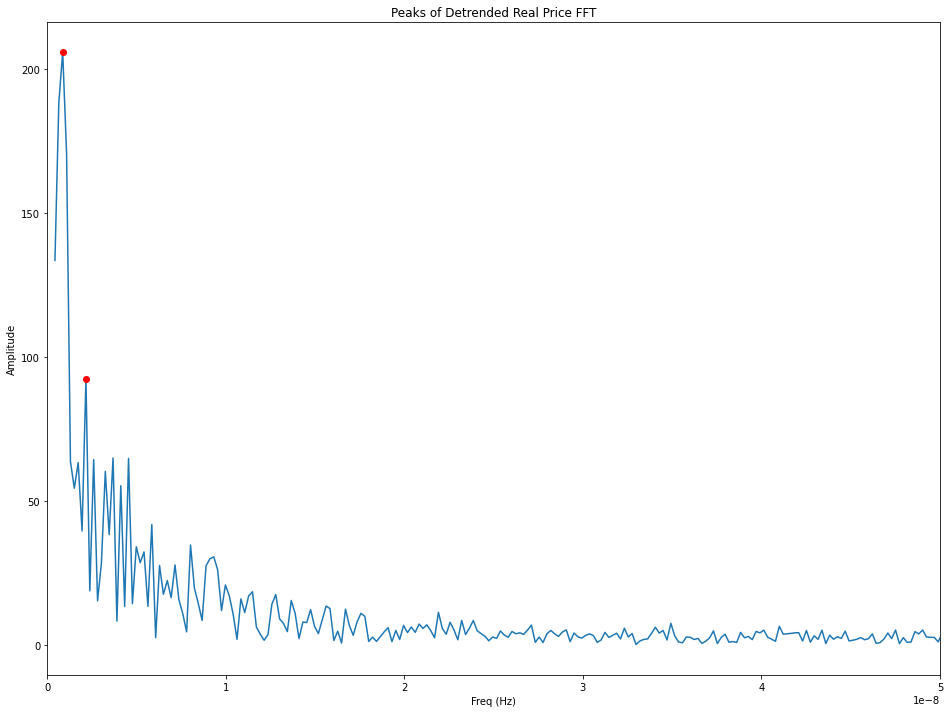

In [84]:
plot_peaks(price_quad_log_fft, quad_log_peak_indices, fft_freq)

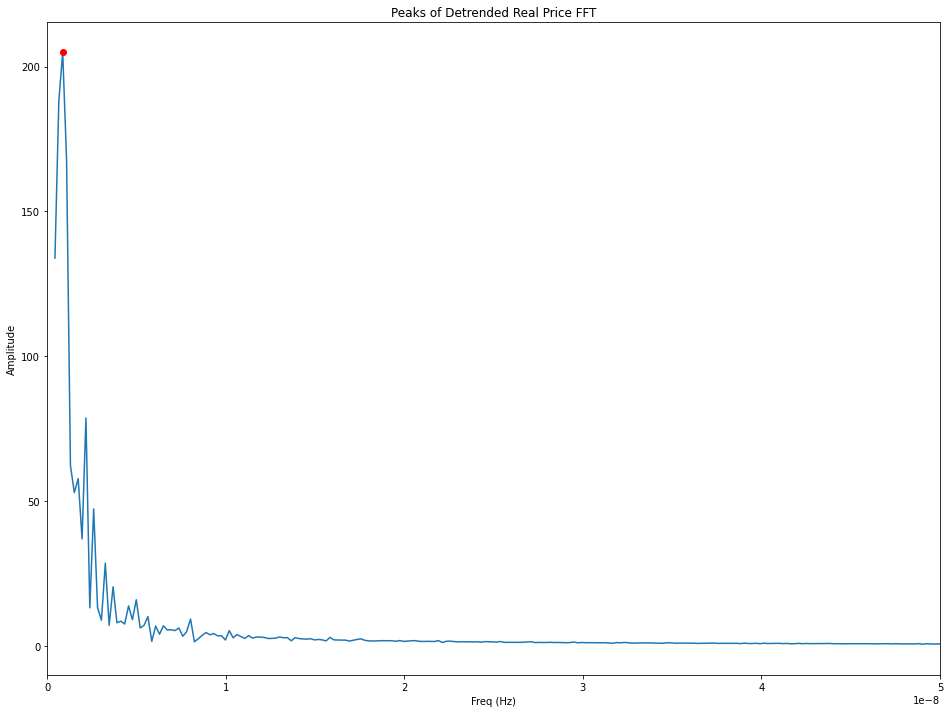

In [85]:
plot_peaks(savgol_filtered_fft, savgol_peak_indices, fft_freq)

In [86]:
def find_seasonality(peak_indices, fft_vals, fft_freqs):
    month_period_list = []
    amplitude_list = []
    for i in peak_indices:
        sec_num = 1/fft_freqs[i] # converting Hz to seconds
        month_num = 12*sec_num/(365*24*60*60) # converting seconds to months
        month_period_list.append(month_num) 
        amplitude_list.append(fft_vals[i])
    return month_period_list, amplitude_list

In [87]:
quad_log_month_periods, quad_log_period_amplitudes = find_seasonality(quad_log_peak_indices, np.abs(price_quad_log_fft), fft_freq)
savgol_month_periods, savgol_period_amplitudes = find_seasonality(savgol_peak_indices, np.abs(savgol_filtered_fft), fft_freq)

In [88]:
print('Possible detrended FFT peaks occur at year periods :{}'.format([month/12 for month in quad_log_month_periods]))
print('The amplitudes at these peaks are :{}'.format([amp for amp in quad_log_period_amplitudes]))

Possible detrended FFT peaks occur at year periods :[36.541666666666664, 14.616666666666667]
The amplitudes at these peaks are :[205.78998397104039, 92.30732868879299]


In [89]:
print('Possible Savitzky-Golay filtered FFT peaks occur at year periods :{}'.format([month/12 for month in savgol_month_periods]))
print('The amplitudes at these peaks are :{}'.format([amp for amp in savgol_period_amplitudes]))

Possible Savitzky-Golay filtered FFT peaks occur at year periods :[36.541666666666664]
The amplitudes at these peaks are :[205.00874122848833]


In [90]:
def isolate_periodicity(fft, amp_height):
    height_peak_indices, height_peak_amplitudes = signal.find_peaks(np.abs(fft), height=amp_height)
    isolated_fft = np.zeros_like(fft)
    for index in height_peak_indices:
        isolated_fft[index] = fft[index]
    plt.figure(figsize=(16, 12))
    plt.title('Isolated Peaks of Detrended Real Price FFT')
    plt.plot(fft_freq[2:], np.abs(isolated_fft)[2:])
    plt.xlabel('Freq (Hz)')
    plt.xlim(0, 0.5*10**-7)
    plt.ylabel('Amplitude')
    plt.show()
    return isolated_fft

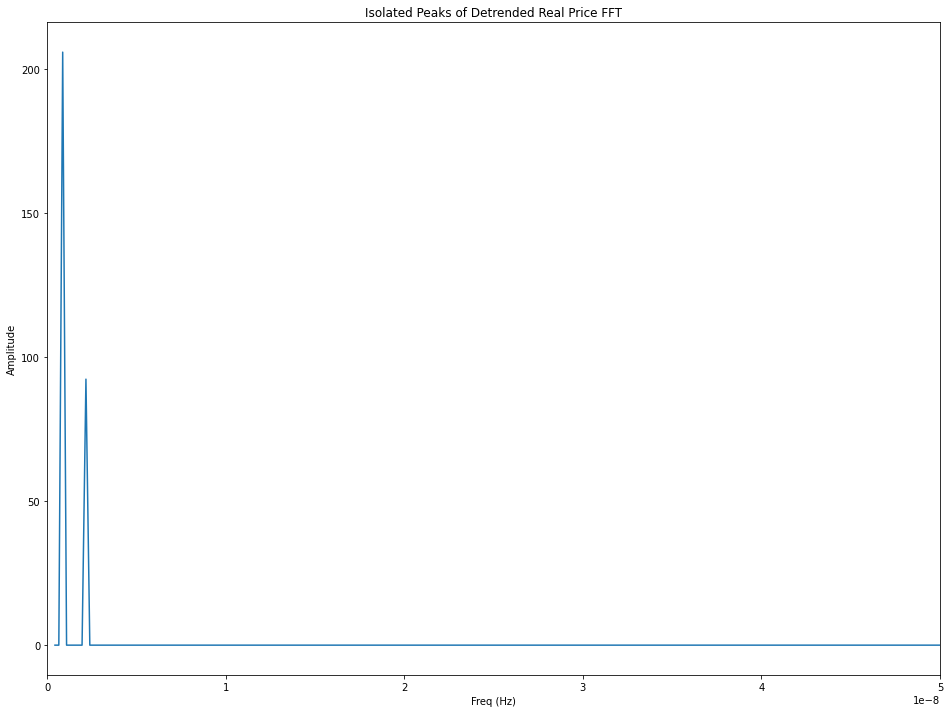

In [91]:
quad_log_peak_isolated_fft = isolate_periodicity(np.abs(price_quad_log_fft), 90)

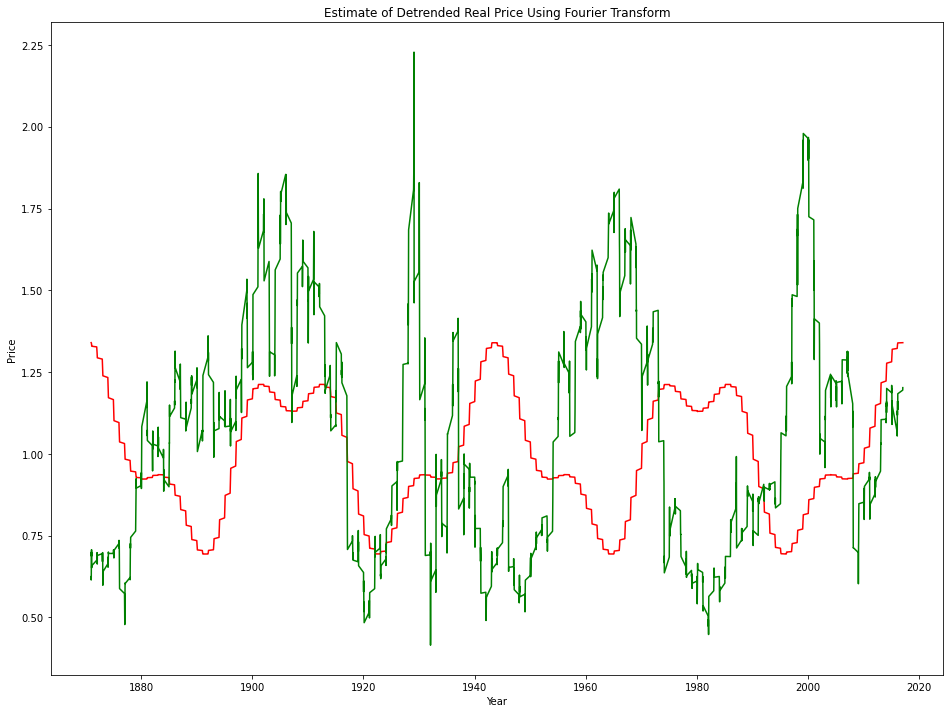

In [92]:
quad_log_periodicity_isolated = fft.irfft(quad_log_peak_isolated_fft)
plt.figure(figsize=(16, 12))
plt.title('Estimate of Detrended Real Price Using Fourier Transform')
plt.xlabel('Year')
plt.ylabel('Price')
plt.plot(date, quad_log_periodicity_isolated+1, 'r', label='Estimate')
plt.plot(date, price_quad_log_detrend, 'g', label='Actual values')
plt.show()

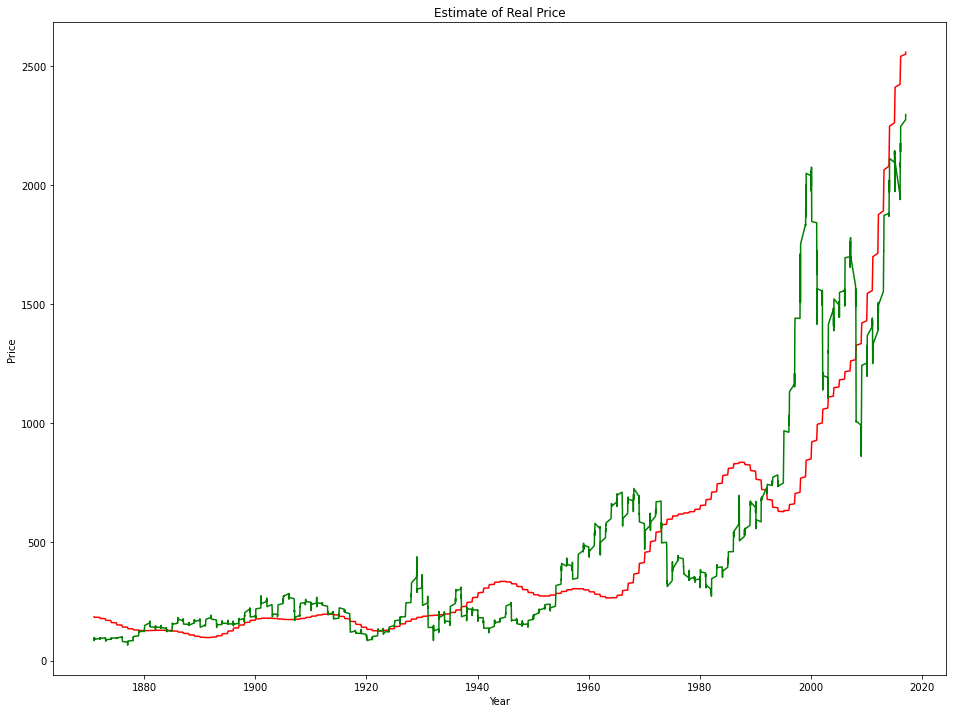

In [93]:
real_price_estimate = (quad_log_periodicity_isolated+1) * log_quad_values
plt.figure(figsize=(16, 12))
plt.title('Estimate of Real Price')
plt.xlabel('Year')
plt.ylabel('Price')
plt.plot(date, real_price_estimate, 'r', label='Estimate')
plt.plot(date, real_price, 'g', label='Actual values')
plt.show()

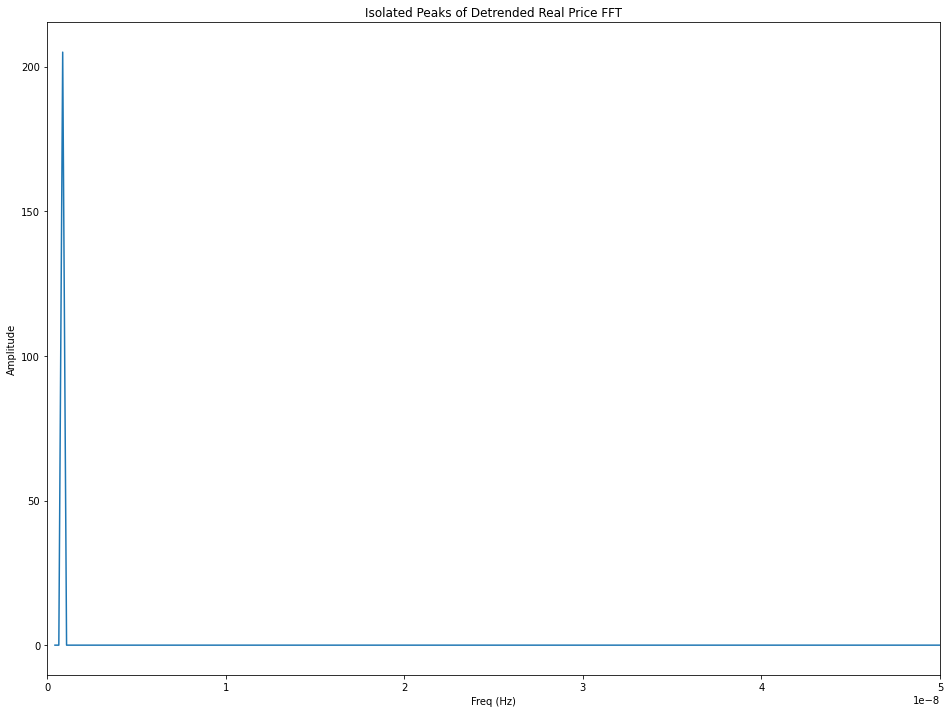

In [94]:
savgol_peak_isolated_fft = isolate_periodicity(np.abs(savgol_filtered_fft), 100)

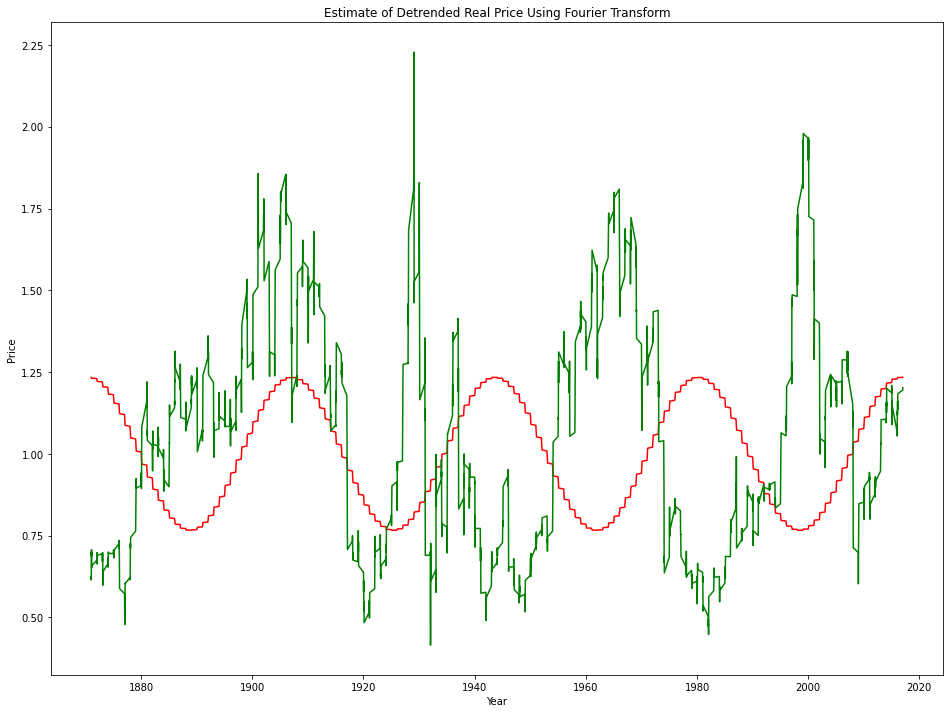

In [95]:
savgol_periodicity_isolated = fft.irfft(savgol_peak_isolated_fft)
plt.figure(figsize=(16, 12))
plt.title('Estimate of Detrended Real Price Using Fourier Transform')
plt.xlabel('Year')
plt.ylabel('Price')
plt.plot(date, savgol_periodicity_isolated+1, 'r', label='Estimate')
plt.plot(date, price_quad_log_detrend, 'g', label='Real values')
plt.show()

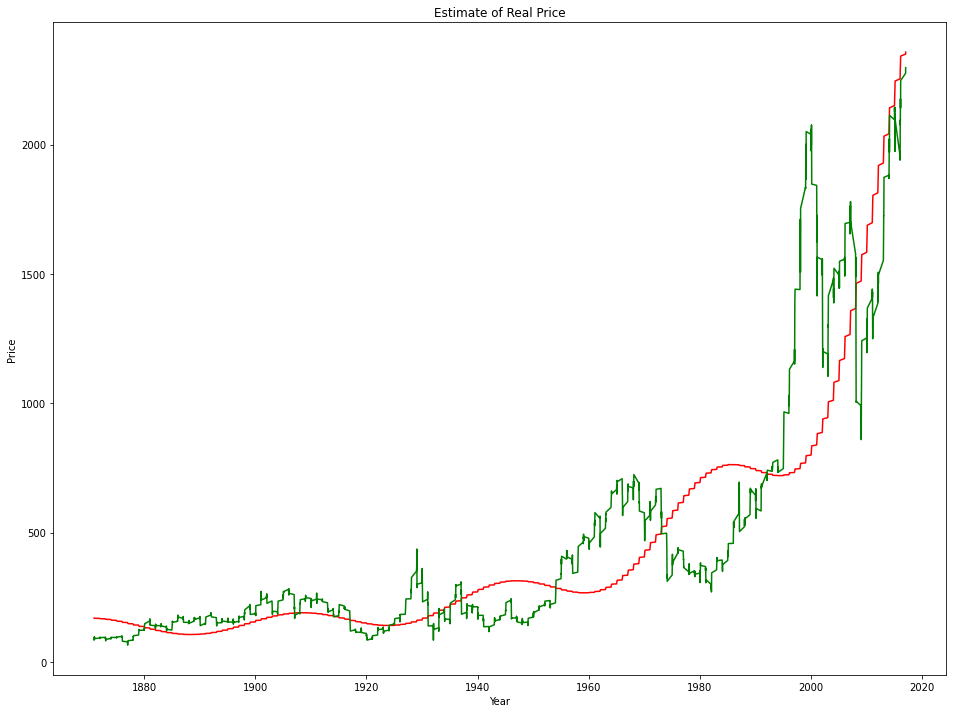

In [96]:
real_price_estimate2 = (savgol_periodicity_isolated+1) * log_quad_values
plt.figure(figsize=(16, 12))
plt.title('Estimate of Real Price')
plt.xlabel('Year')
plt.ylabel('Price')
plt.plot(date, real_price_estimate2, 'r', label='Estimate')
plt.plot(date, real_price, 'g', label='Actual values')
plt.show()

In [97]:
def plot_periods(period_len):
    int_period_len = round(period_len)
    plt.figure()
    plt.title('Savitzky-Golay Filtered Detrended Real Price with Period ({} months'.format(int_period_len))
    plt.xlabel('Year')
    plt.ylabel('Price')
    for period in np.arange(0, len(date), period_len):
        plt.axvline(x=period, color='r', ls='--')
    plt.plot(period_list, savgol_filtered_detrend)
    plt.grid()
    plt.show()

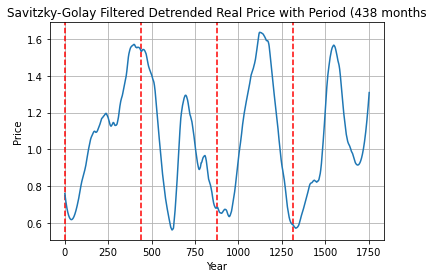

In [98]:
for period in savgol_month_periods:
    plot_periods(period)

In [99]:
savgol_month_periods[0]

438.5

In [100]:
months_per_period = round(savgol_month_periods[0])

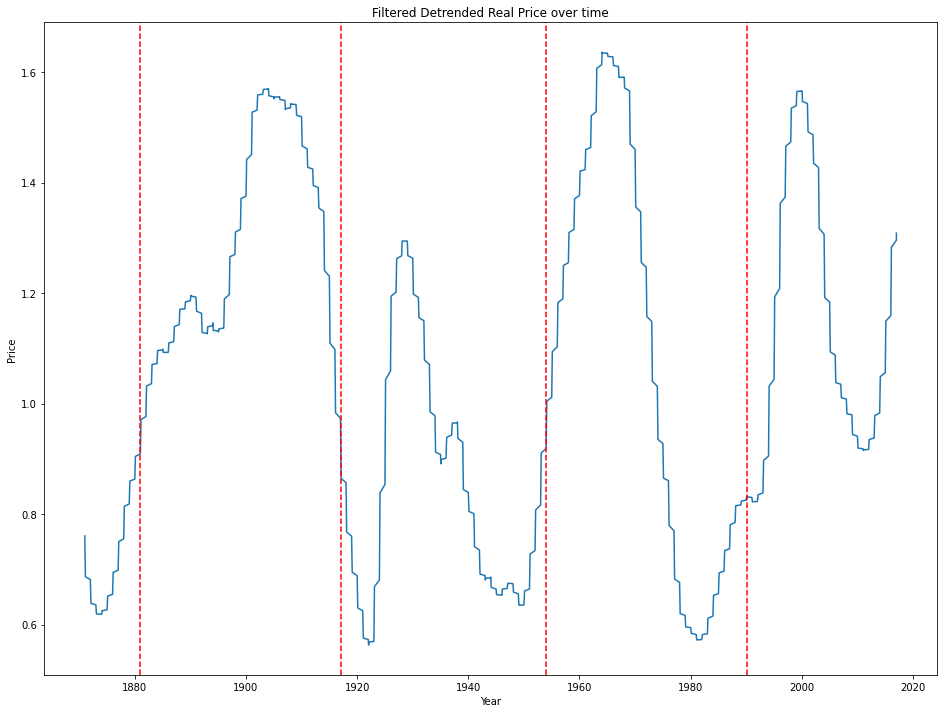

In [101]:
plt.figure(figsize=(16, 12))
plt.title('Filtered Detrended Real Price over time')
plt.xlabel('Year')
plt.ylabel('Price')
plt.plot(date, savgol_filtered_detrend)
for year in np.arange(10*12, len(date), months_per_period):
    x_tick = date[year]    
    plt.axvline(x=x_tick, color='r', ls='--')
plt.show()

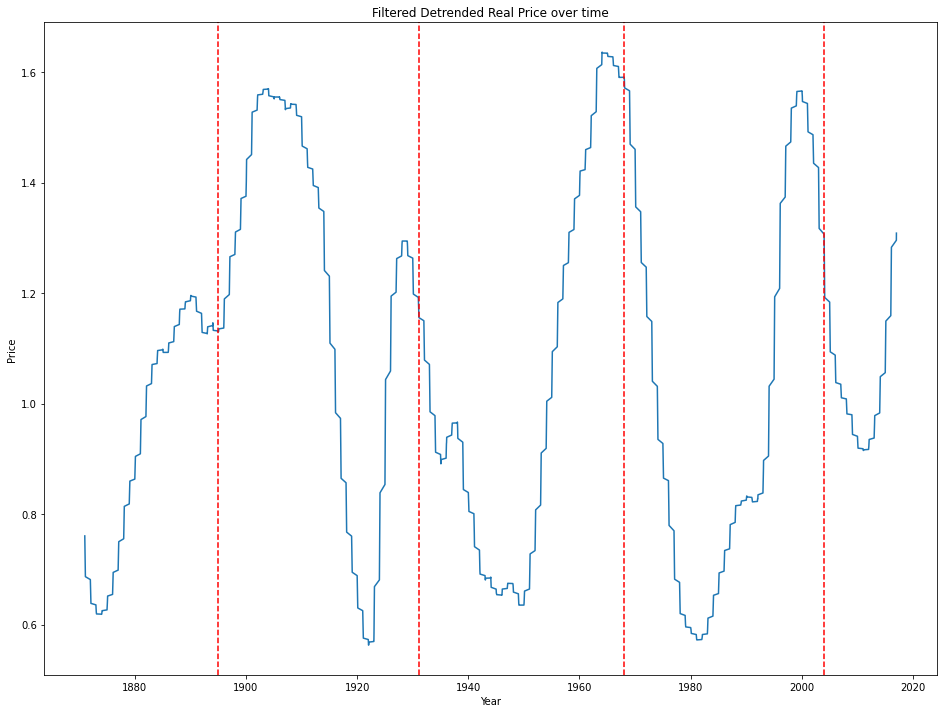

In [102]:
plt.figure(figsize=(16, 12))
plt.title('Filtered Detrended Real Price over time')
plt.xlabel('Year')
plt.ylabel('Price')
plt.plot(date, savgol_filtered_detrend)
for year in np.arange(24*12, len(date), months_per_period):
    x_tick = date[year]    
    plt.axvline(x=x_tick, color='r', ls='--')
plt.show()

From the above plot we can see suggestions that, from roughly 22 years into the timeseries (01/1893), the detrended data may contain an approximate periodicity, of roughly 29 years, corresponding to the frequency of the highest amplitude in our FFT.

The approximate periodicity seems to be largely dictated by 3 key points in time where there are troughs seen in the detrended time series. A sharp drop is seen in the mid 1910s, at the start of the First World War. Other drops are seen in the years starting from the Wall Street Crash in 1929, and surrounding World War 2, 1939-1945. The final fall is ween in the late 70s to early 80s, when there was a recession affecting many countries in the world.

##Task 3

Refine your analysis by adjusting the size of the dataset (e.g. if you model annual patterns, make sure your dataset size is a multiple of 12).

In [103]:
def refine_dataset(dataset, start_date, months_per_period, num_periods):
    start_index = date.tolist().index(start_date)
    end_index = start_index + months_per_period * num_periods
    refined_date = date[start_index:end_index]
    refined_dataset = dataset[start_index:end_index]
    return refined_dataset, refined_date

In [104]:
(date[0], date[-1])

(1871.01, 2017.02)

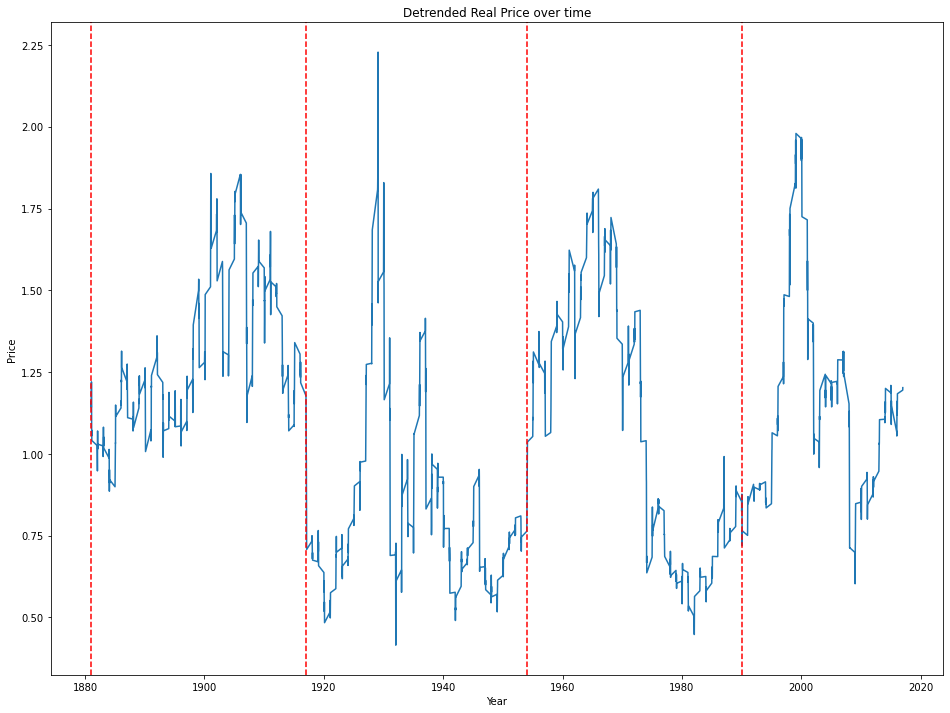

In [105]:
refined_detrend, refined_date = refine_dataset(price_quad_log_detrend, 1881.01, months_per_period, 5)
plt.figure(figsize=(16, 12))
plt.title('Detrended Real Price over time')
plt.xlabel('Year')
plt.ylabel('Price')
plt.plot(refined_date, refined_detrend)
for year in np.arange(0, len(refined_date), months_per_period):
    x_tick = refined_date[year]    
    plt.axvline(x=x_tick, color='r', ls='--')
plt.show()

In [106]:
def find_refined_periodicities(start_date, months_per_period, period_num, height):
    refined_detrend, refined_refined_date = refine_dataset(price_quad_log_detrend, start_date, months_per_period, 1)
    refined_fft = fft.rfft(refined_detrend)
    refined_fft_freq = np.fft.rfftfreq(len(refined_detrend), d=1/timeseries_samplerate)
    refined_peak_indices, refined_peak_amplitudes = signal.find_peaks(np.abs(refined_fft), height=height)
    refined_month_periods, refined_period_amplitudes = find_seasonality(refined_peak_indices, np.abs(refined_fft), refined_fft_freq)

    plt.figure(figsize=(16, 12))
    plt.title('Period {} Detrended Real Price FFT'.format(period_num))
    plt.plot(refined_fft_freq[2:], np.abs(refined_fft[2:]))
    plt.xlabel('Freq (Hz)')
    plt.ylabel('Amplitude')
    plt.show()
    
    print('Possible detrended FFT peaks occur at year periods :{}'.format([month/12 for month in refined_month_periods]))
    print('The amplitudes at these peaks are :{}'.format([amp for amp in refined_period_amplitudes]))

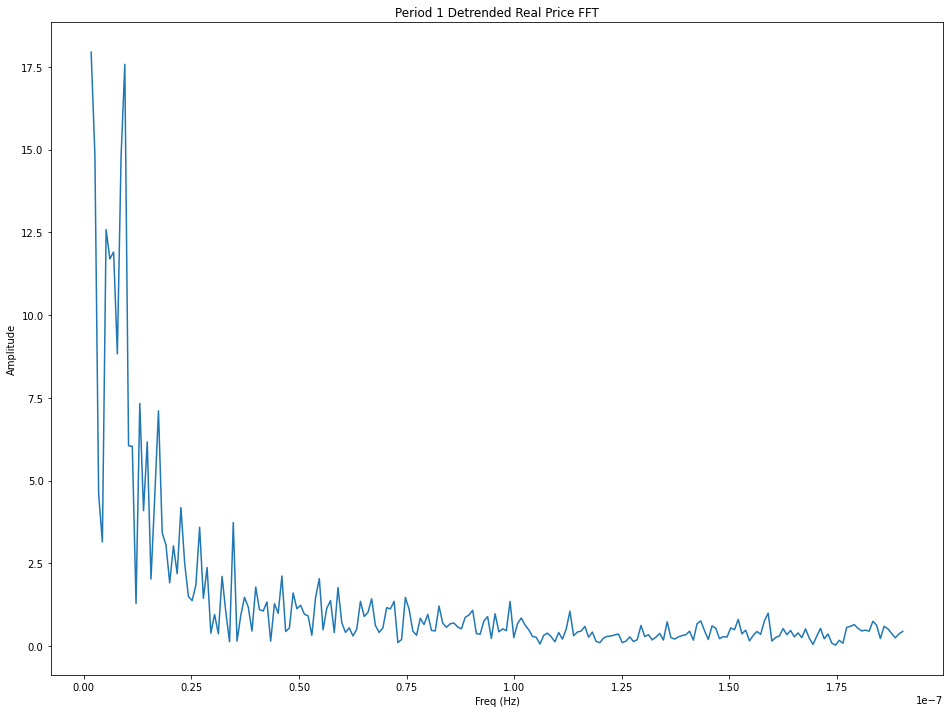

Possible detrended FFT peaks occur at year periods :[6.083333333333332, 4.5625, 3.318181818181818]
The amplitudes at these peaks are :[12.585343931767833, 11.911477284899078, 17.582560683261207]


In [107]:
find_refined_periodicities(1881.01, months_per_period, 1, 10)

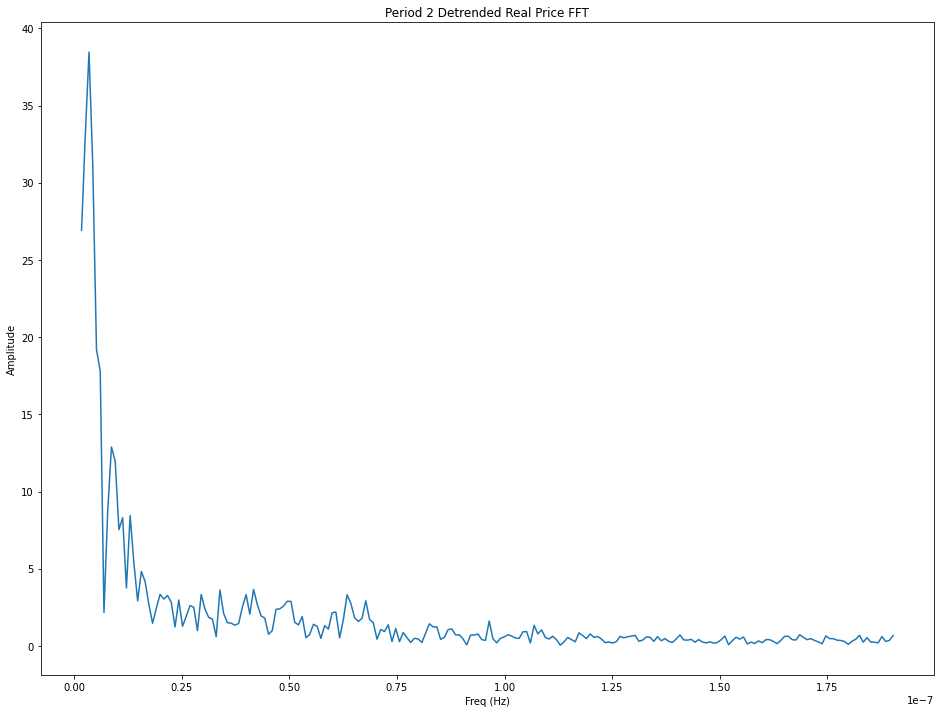

Possible detrended FFT peaks occur at year periods :[9.125, 3.65]
The amplitudes at these peaks are :[38.46186381158378, 12.887150052540521]


In [108]:
find_refined_periodicities(1917.07, months_per_period, 2, 10)

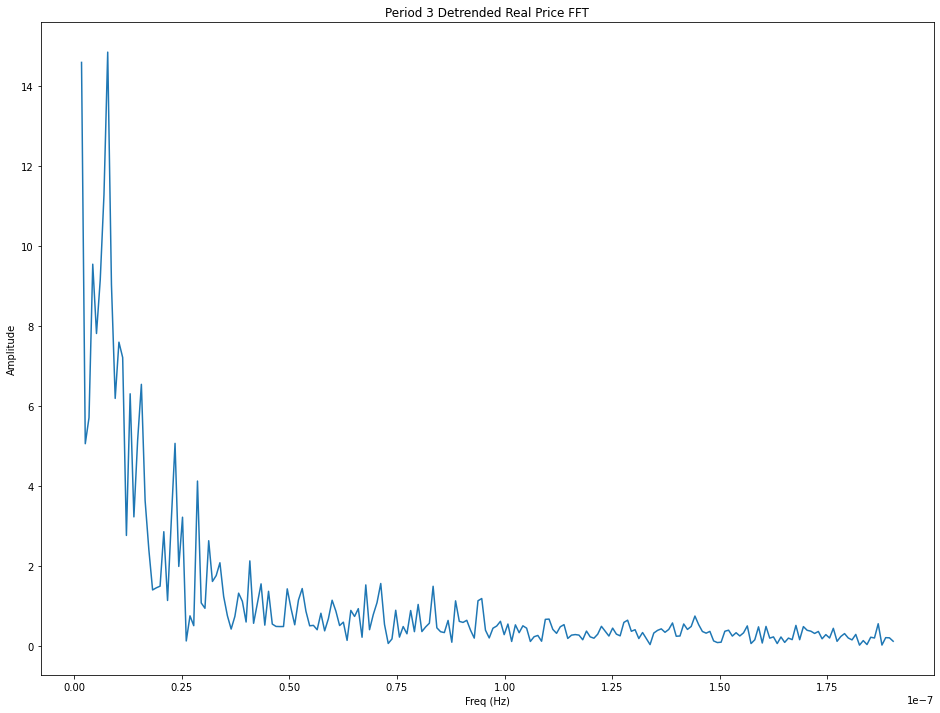

Possible detrended FFT peaks occur at year periods :[4.0555555555555545]
The amplitudes at these peaks are :[14.856946585179148]


In [109]:
find_refined_periodicities(1954.01, months_per_period, 3, 10)

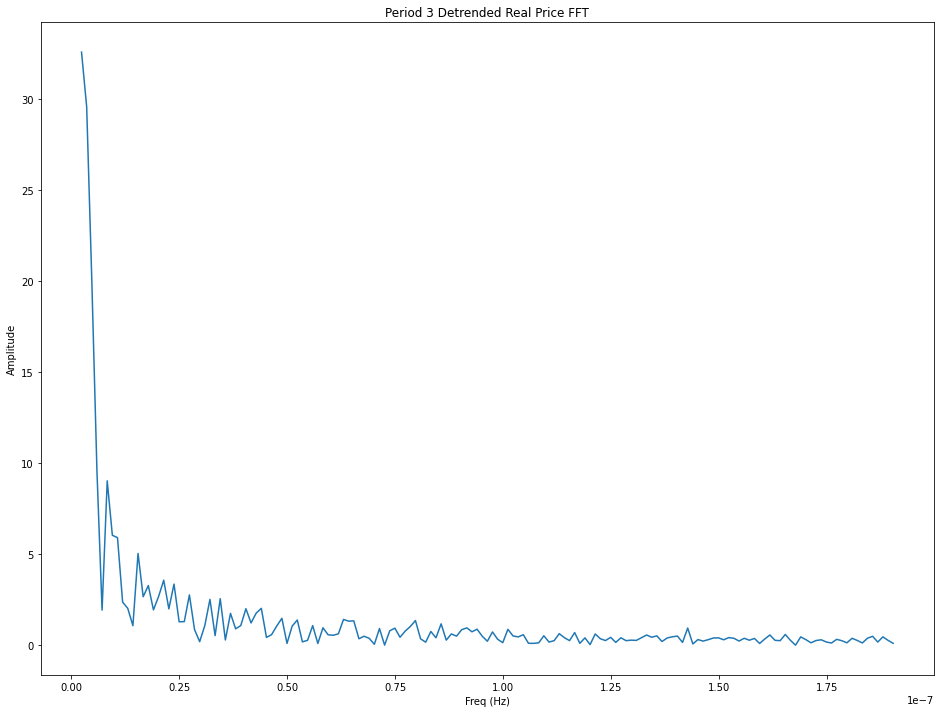

Possible detrended FFT peaks occur at year periods :[3.809523809523809, 2.0512820512820515]
The amplitudes at these peaks are :[9.035502528415137, 5.044116430023632]


In [110]:
find_refined_periodicities(1990.07, months_per_period, 3, 5)

### 3. Yearly Periodicities

In [111]:
def get_month_average(time_series, month_index):
    month_samples = [time_series[i] for i in range(month_index, len(time_series), 12)]
    return sum(month_samples) / len(month_samples)

In [112]:
month_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
year_average_detrend = []
for month_index in range(12):
    year_average_detrend.append(get_month_average(price_quad_log_detrend, month_index))

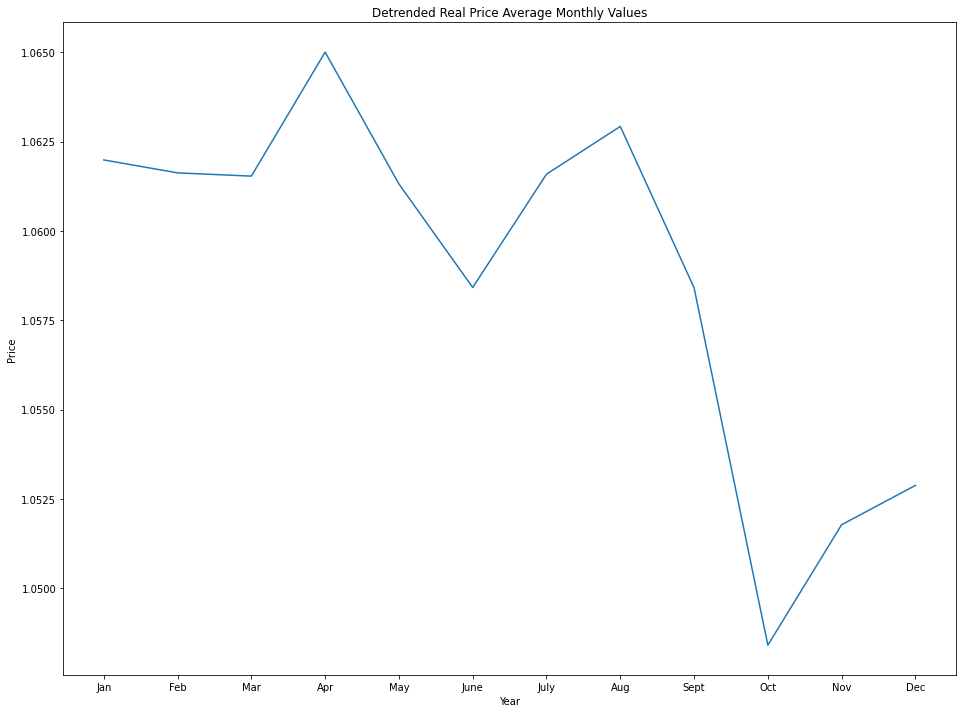

In [113]:
plt.figure(figsize=(16, 12))
plt.title('Detrended Real Price Average Monthly Values')
plt.xlabel('Year')
plt.ylabel('Price')
plt.plot(month_list, year_average_detrend)
plt.show()

In [114]:
excess_months = len(price_quad_log_detrend) % 12
full_years = int((len(price_quad_log_detrend) - excess_months)/12)
extended_year_average_detrend = year_average_detrend * full_years + year_average_detrend[:excess_months]

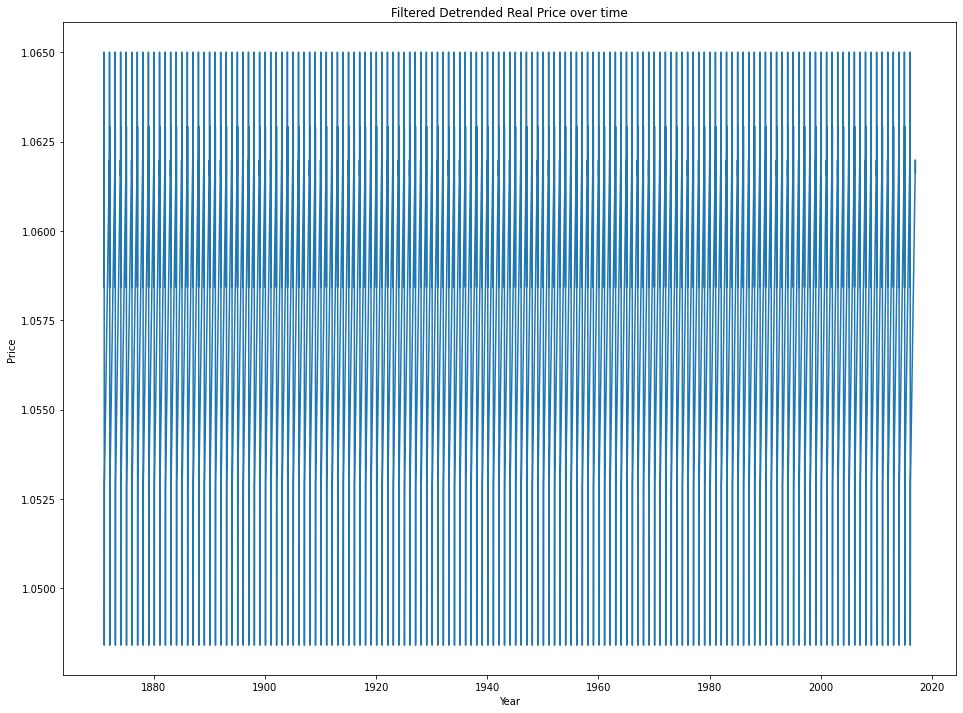

In [115]:
plt.figure(figsize=(16, 12))
plt.title('Filtered Detrended Real Price over time')
plt.xlabel('Year')
plt.ylabel('Price')
plt.plot(date, extended_year_average_detrend)
plt.show()

In [116]:
year_average_fft = fft.rfft(extended_year_average_detrend)
year_average_fft_freq = np.fft.rfftfreq(len(extended_year_average_detrend), d=1/timeseries_samplerate)

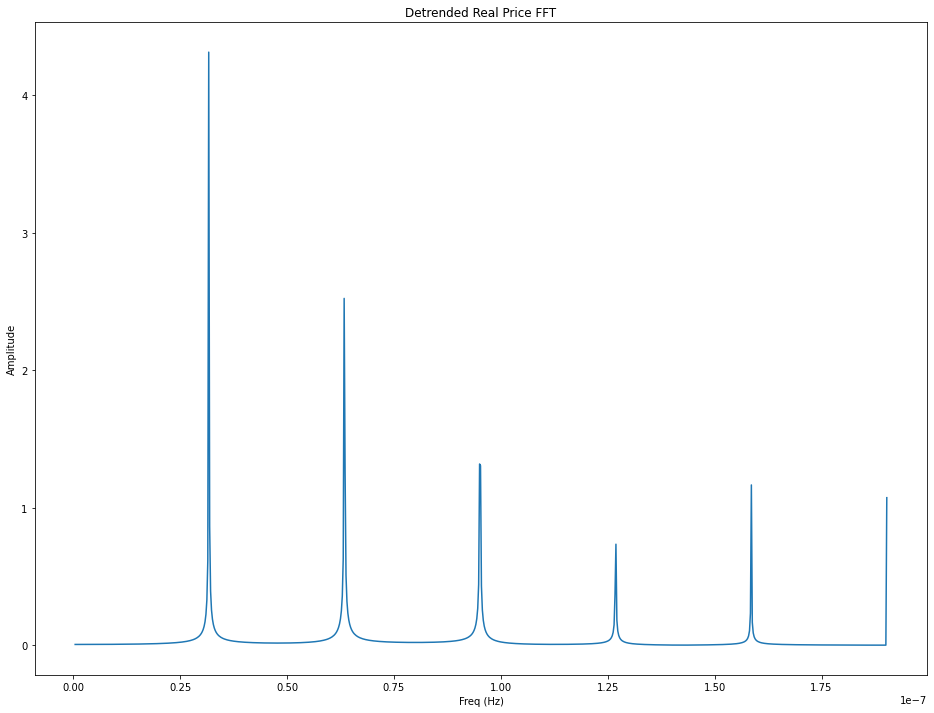

In [117]:
plt.figure(figsize=(16, 12))
plt.title('Detrended Real Price FFT')
plt.plot(year_average_fft_freq[2:], np.abs(year_average_fft[2:]))
plt.xlabel('Freq (Hz)')
plt.ylabel('Amplitude')
plt.show()

In [118]:
year_average_peak_indices, year_average_peak_amplitudes = signal.find_peaks(np.abs(year_average_fft), height=2)

In [119]:
year_average_month_periods, year_average_period_amplitudes = find_seasonality(year_average_peak_indices, np.abs(year_average_fft), fft_freq)

In [120]:
print('Possible detrended FFT peaks occur at month periods :{}'.format([month for month in year_average_month_periods]))
print('The amplitudes at these peaks are :{}'.format([amp for amp in year_average_period_amplitudes]))

Possible detrended FFT peaks occur at month periods :[12.013698630136984, 6.006849315068492]
The amplitudes at these peaks are :[4.3152271657176104, 2.5235484361512928]
